In [277]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')

## 1. Download/Load S&P Stock Price Data

In [397]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

response = requests.get(url, headers=headers)

response.raise_for_status()

sp500 = pd.read_html(response.text)[0]


sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


symbol_list = sp500['Symbol'].unique().tolist()


end_date = '2025-09-16'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=10)

df = yf.download(tickers=symbol_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-16 A       33.657143  36.520000  36.869999  36.060001  36.150002   
           AAPL    26.160303  29.102501  29.135000  28.860001  29.062500   
           ABBV    39.185940  59.509998  59.639999  58.630001  59.500000   
           ABT     36.280643  43.860001  44.090000  43.560001  43.779999   
           ACGL    22.317587  23.469999  23.510000  23.323334  23.450001   
           ACN     83.595543  98.959999  99.349998  98.059998  98.220001   
           ADBE    80.529999  80.529999  80.669998  79.320000  79.510002   
           ADI     47.821598  58.450001  58.549999  57.750000  58.540001   
           ADM     32.824345  44.189999  44.220001  43.410000  43.660000   
           ADP     64.198189  79.589996  79.800003  78.760002  78.930000   

Price                   volume  garman_klass_vol  rsi  bb_low  bb_mid  \
date       ticker                                                       
2015-09-16 A         2130100.0         -0.001725  NaN     NaN     NaN   
           AAPL    148694000.0         -0.004231  NaN     NaN     NaN   
           ABBV      8044200.0         -0.067239  NaN     NaN     NaN   
           ABT       4982300.0         -0.013564  NaN     NaN     NaN   
           ACGL       803400.0         -0.000915  NaN     NaN     NaN   
           ACN       1741900.0         -0.009955  NaN     NaN     NaN   
           ADBE      2509800.0          0.000080  NaN     NaN     NaN   
           ADI       2085300.0         -0.015704  NaN     NaN     NaN   
           ADM       2990300.0         -0.031264  NaN     NaN     NaN   
           ADP       1739600.0         -0.016400  NaN     NaN     NaN   

Price              bb_high  bb_position  atr  macd  dollar_volume  
date       ticker                                                  
2015-09-16 A           NaN          NaN  NaN   NaN      71.693080  
           AAPL        NaN          NaN  NaN   NaN    3889.880112  
           ABBV        NaN          NaN  NaN   NaN     315.219537  
           ABT         NaN          NaN  NaN   NaN     180.761050  
           ACGL        NaN          NaN  NaN   NaN      17.929949  
           ACN         NaN          NaN  NaN   NaN     145.615076  
           ADBE        NaN          NaN  NaN   NaN     202.114191  
           ADI         NaN          NaN  NaN   NaN      99.722378  
           ADM         NaN          NaN  NaN   NaN      98.154638  
           ADP         NaN          NaN  NaN   NaN     111.679169

#### ETFS Download

In [169]:
import requests
import pandas as pd
import yfinance as yf
from io import StringIO

import requests
import pandas as pd

url = 'https://api.nasdaq.com/api/screener/etf?download=true'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
response.raise_for_status()

data = response.json()


etf_rows = data['data']['data']['rows']
etf_df = pd.DataFrame(etf_rows)

etf_df['symbol'] = etf_df['symbol'].str.replace('.', '-', regex=False)
etf_list = etf_df['symbol'].dropna().unique().tolist()


end_date = '2025-09-16'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)


def download_batched_etfs(tickers, batch_size=100):
    frames = []
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i+batch_size]
        print(f"Downloading batch {i} to {i+len(batch)}...")
        df_batch = yf.download(
            tickers=batch,
            start=start_date,
            end=end_date,
            auto_adjust=False,
            group_by='ticker'
        )
        frames.append(df_batch)
    return pd.concat(frames, axis=1)

raw_df = download_batched_etfs(etf_list)

df = (raw_df.stack(level=0).sort_index().rename_axis(index=['date', 'ticker']).reset_index())

df.columns = [col.lower() if isinstance(col, str) else col for col in df.columns]
df = df.set_index(['date', 'ticker'])

df


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed

2 Failed downloads:
['SOLT', 'FLEE']: YFPricesMissingError('possibly delisted; no price data found  (1d 2017-09-16 00:00:00 -> 2025-09-16)')


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  100 of 100 completed


[*********************100%***********************]  70 of 70 completed


open       high        low      close  adj close  \
date       ticker                                                          
2017-09-18 AADR    56.070000  56.070000  54.790001  55.009998  50.474274   
           AAVM    26.889999  26.889999  26.809999  26.818001  23.571371   
           AAXJ    73.820000  73.919998  73.610001  73.760002  63.303848   
           ABFL    30.580000  30.580000  30.520000  30.520000  26.311293   
           ABLG    26.330000  26.330000  26.329000  26.330000  21.393049   
...                      ...        ...        ...        ...        ...   
2025-09-15 ZTEN    51.779999  51.869999  51.779999  51.826000  51.826000   
           ZTOP    52.749001  52.749001  52.749001  52.749001  52.484001   
           ZTRE    51.410000  51.419998  51.389999  51.404999  51.404999   
           ZTWO    50.930000  50.930000  50.924999  50.924999  50.924999   
           ZVOL    12.370000  12.400000  12.312000  12.312000  12.312000   

                     volume  
date       ticker            
2017-09-18 AADR     44300.0  
           AAVM      2100.0  
           AAXJ    934000.0  
           ABFL      2100.0  
           ABLG      1100.0  
...                     ...  
2025-09-15 ZTEN      3500.0  
           ZTOP       100.0  
           ZTRE      1600.0  
           ZTWO      2100.0  
           ZVOL     13900.0  

[4700912 rows x 6 columns]

## 2. Calculate Features and Technical Indicators for each Stock
* Garman-Klass Volatility
* RSI
* Bollinger Brands
    - The distance between the bands indicates volatility
    - Prices nearing or touching the upper band can suggest an asset is $\textbf{overbought}$
    - Prices nearing or touching the lower band can suggest an asset is $\textbf{oversold}$
* ATR
    - Volatility of stock over certain range
* MACD
* DOllar Volume

Garman-KlassVolatility $ =\frac{(ln(High)-ln(Low))^2}{2}-(2\ln(2)-1)(\ln(\text{Adj Close})-\ln(\text{Open}))^2$

In [398]:
# Garman-Klass Volatility
df['garman_klass_vol'] = (
    ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
    - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2
)

# RSI
df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

#df['rsi_state'] = np.select(
#    [df['rsi'] < 30, df['rsi'] > 70],
#    [-1, 1],
#    default=0
#)


# Bollinger Bands
def compute_bb(group, key):
 # log_close = np.log1p(group['adj close'])
 # bb = ta.bbands(close=log_close, length=20)
  bb = ta.bbands(close=group['adj close'], length=20)
  return bb.iloc[:,key]

df['bb_low'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 0)
df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 1)
df['bb_high'] = df.groupby('ticker', group_keys=False).apply(compute_bb, 2)

df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))



# ATR
def compute_atr(group):
    atr = ta.atr(group['high'], group['low'], group['close'], length=14)
    #return (atr - atr.mean()) / atr.std()
    return atr

df['atr'] = df.groupby('ticker', group_keys=False).apply(compute_atr)


# MACD
def compute_macd(group):
    macd_line = ta.macd(group, length=20).iloc[:, 0]
    #return (macd_line - macd_line.mean()) / macd_line.std()
    return macd_line

df['macd'] = df.groupby('ticker')['adj close'].transform(compute_macd)


# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

df


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-16 A        33.657146   36.520000   36.869999   36.060001   36.150002   
           AAPL     26.160305   29.102501   29.135000   28.860001   29.062500   
           ABBV     39.185944   59.509998   59.639999   58.630001   59.500000   
           ABT      36.280643   43.860001   44.090000   43.560001   43.779999   
           ACGL     22.317587   23.469999   23.510000   23.323334   23.450001   
...                       ...         ...         ...         ...         ...   
2025-09-15 XYZ      74.629997   74.629997   75.199997   73.099998   73.330002   
           YUM     148.899994  148.899994  150.320007  148.899994  149.800003   
           ZBH     100.959999  100.959999  103.500000  100.769997  103.160004   
           ZBRA    320.910004  320.910004  323.929993  313.010010  314.760010   
           ZTS     146.250000  146.250000  149.750000  145.889999  148.080002   

Price                   volume  garman_klass_vol        rsi      bb_low  \
date       ticker                                                         
2015-09-16 A         2130100.0         -0.001725        NaN         NaN   
           AAPL    148694000.0         -0.004231        NaN         NaN   
           ABBV      8044200.0         -0.067239        NaN         NaN   
           ABT       4982300.0         -0.013564        NaN         NaN   
           ACGL       803400.0         -0.000915        NaN         NaN   
...                        ...               ...        ...         ...   
2025-09-15 XYZ       6474800.0          0.000282  49.763831   71.583943   
           YUM       2605300.0          0.000031  55.242134  142.766756   
           ZBH        957800.0          0.000178  48.786230  101.297324   
           ZBRA       486300.0          0.000443  52.450974  302.568635   
           ZTS       3340600.0          0.000281  39.134689  147.096424   

Price                  bb_mid     bb_high  bb_position       atr      macd  \
date       ticker                                                            
2015-09-16 A              NaN         NaN          NaN       NaN       NaN   
           AAPL           NaN         NaN          NaN       NaN       NaN   
           ABBV           NaN         NaN          NaN       NaN       NaN   
           ABT            NaN         NaN          NaN       NaN       NaN   
           ACGL           NaN         NaN          NaN       NaN       NaN   
...                       ...         ...          ...       ...       ...   
2025-09-15 XYZ      76.280501   80.977059     0.324286  2.379134 -0.257966   
           YUM     146.833934  150.901112     0.753992  2.611252  0.747923   
           ZBH     104.861000  108.424676    -0.047328  2.005949  0.886500   
           ZBRA    314.289499  326.010363     0.782424  8.726368 -1.497989   
           ZTS     153.068498  159.040573    -0.070865  3.198553 -1.137967   

Price              dollar_volume  
date       ticker                 
2015-09-16 A           71.693088  
           AAPL      3889.880395  
           ABBV       315.219568  
           ABT        180.761050  
           ACGL        17.929949  
...                          ...  
2025-09-15 XYZ        483.214306  
           YUM        387.929154  
           ZBH         96.699487  
           ZBRA       156.058535  
           ZTS        488.562750  

[1230220 rows x 15 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month
- High dollar volume signifies that many shares have been bought and sold, indicating a liquid market where it's easy to execute large trades without significantly impacting the price

In [456]:

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()
data



dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-10-31 A           80.118140   34.900944         -0.002269  59.286440   
           AAPL      5166.718931   26.854708         -0.005360  43.683429   
           ABBV       431.407387   39.574181         -0.054442  61.389296   
           ABT        276.224878   37.273388         -0.014246  68.478245   
           ACGL        32.976217   23.737597         -0.001129  50.888128   
...                          ...         ...               ...        ...   
2025-09-30 XYZ        388.301411   74.629997          0.000282  49.763831   
           YUM        277.614675  148.899994          0.000031  55.242134   
           ZBH        124.066471  100.959999          0.000178  48.786230   
           ZBRA       157.514978  320.910004          0.000443  52.450974   
           ZTS        375.526804  146.250000          0.000281  39.134689   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2015-10-31 A        31.919272   33.484949   35.050625     0.952199  0.723051   
           AAPL     24.006909   25.550848   27.094786     0.922251  0.650628   
           ABBV     32.925906   36.117766   39.309625     1.041442  2.653936   
           ABT      32.550687   35.206581   37.862475     0.889098  0.901721   
           ACGL     23.609273   24.283096   24.956918     0.095220  0.397099   
...                       ...         ...         ...          ...       ...   
2025-09-30 XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   
           YUM     142.766756  146.833934  150.901112     0.753992  2.611252   
           ZBH     101.297324  104.861000  108.424676    -0.047328  2.005949   
           ZBRA    302.568635  314.289499  326.010363     0.782424  8.726368   
           ZTS     147.096424  153.068498  159.040573    -0.070865  3.198553   

                       macd  
date       ticker            
2015-10-31 A       0.679225  
           AAPL    0.377773  
           ABBV   -0.281189  
           ABT     0.761861  
           ACGL    0.479628  
...                     ...  
2025-09-30 XYZ    -0.257966  
           YUM     0.747923  
           ZBH     0.886500  
           ZBRA   -1.497989  
           ZTS    -1.137967  

[58714 rows x 10 columns]

#### Calculate 5 year rolling average of dollar volume for each stock before filtering

In [457]:
data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank'],axis=1)
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-09-30 AAPL      3943.235244   25.948414         -0.002387  59.146272   
           ABBV       336.526429   43.135975         -0.053813  43.768498   
           ABT        292.963622   35.842865         -0.008790  50.322681   
           ACN        239.098658  105.323624         -0.008090  68.571077   
           ADBE       270.127673  108.540001          0.000079  64.922458   
...                          ...         ...               ...        ...   
2025-09-30 WDAY       498.825365  222.750000          0.000202  43.892892   
           WFC       1016.362864   81.410004          0.000034  54.547683   
           WMT       1164.826426  103.690002          0.000015  61.280734   
           XOM       1652.477782  112.349998          0.000051  55.867578   
           XYZ       1181.866235   74.629997          0.000282  49.763831   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2016-09-30 AAPL     23.809071   25.492450   27.175830     0.635431  0.491689   
           ABBV     42.709368   43.689969   44.670571     0.217523  0.985565   
           ABT      34.495348   35.363569   36.231791     0.776022  0.723171   
           ACN      91.777136   97.956483  104.135829     1.096110  2.286403   
           ADBE     95.512353  103.701000  111.889646     0.795470  1.709989   
...                       ...         ...         ...          ...       ...   
2025-09-30 WDAY    220.774320  227.982001  235.189681     0.137054  5.841061   
           WFC      76.980642   80.291001   83.601361     0.669015  1.614933   
           WMT      94.252329   99.709001  105.165673     0.864783  1.633346   
           XOM     106.948198  111.234000  115.519803     0.630197  1.887324   
           XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   

                       macd  
date       ticker            
2016-09-30 AAPL    0.401846  
           ABBV   -0.209572  
           ABT    -0.171002  
           ACN     1.207961  
           ADBE    2.225492  
...                     ...  
2025-09-30 WDAY   -0.776716  
           WFC     0.485723  
           WMT     1.092913  
           XOM     0.864059  
           XYZ    -0.257966  

[16241 rows x 10 columns]

## Monthly return predictor

In [ ]:
data = yf.download('AAPL', start="2010-01-28", end="2025-04-14",auto_adjust=False, interval="1wk")

values = data['Adj Close']#.rolling(window=4).mean()
values

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2010-02-01,6.142717
2010-03-01,7.054726
2010-04-01,7.837955
2010-05-01,7.711565
2010-06-01,7.550961
...,...
2024-12-01,249.534180
2025-01-01,235.165192
2025-02-01,240.984528


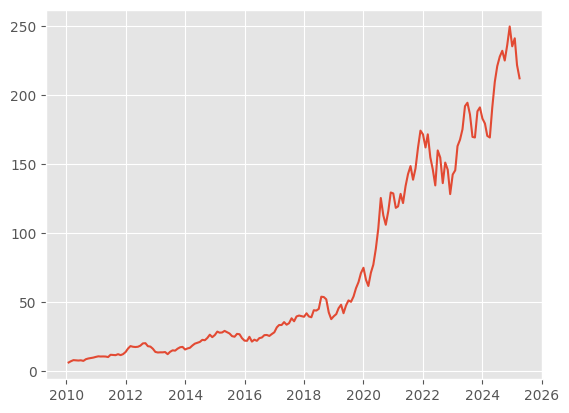

In [394]:
plt.plot(values)

[*********************100%***********************]  1 of 1 completed


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 0.0882 - val_loss: 0.8805
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0391 - val_loss: 0.1078
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0289 - val_loss: 0.0810
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0185 - val_loss: 0.0778
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0117 - val_loss: 0.1024
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0062 - val_loss: 0.3751
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0051 - val_loss: 0.4803
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0054 - val_loss: 0.4898
Epoch 9/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0053 - val_loss: 0.4008
Epoch 10/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0057 - val_loss: 0.3923
Epoch 11/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0068 - val_loss: 0.1828
Epoch 12/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0061 - val_loss: 0.4361


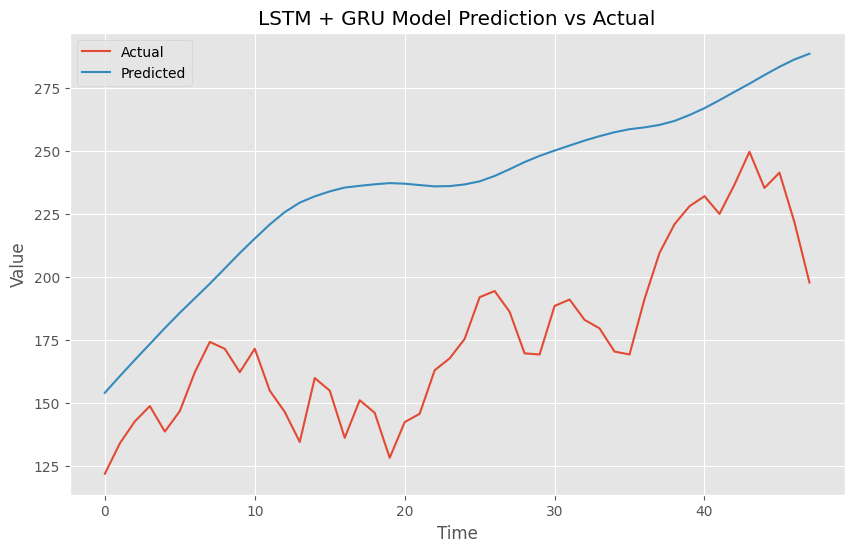

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Lion, Adamax, RMSprop, Nadam, Ftrl, Adadelta, Adagrad, LossScaleOptimizer
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
# unique tickers in data
#unique_tickers = data.index.get_level_values('ticker').unique().tolist()

# get daily adjusted close prices for unique tickers from df which is multi-indexed by date and ticker
"""price_per_month_df = df.loc[(df.index.get_level_values('ticker').isin(unique_tickers))].copy()
price_per_month_df

df_unstacked = df.unstack(level=1)
df_unstacked = df_unstacked['adj close'] 
filtered_adj_close = df_unstacked[unique_tickers]
filtered_adj_close = filtered_adj_close.resample('M').last()
filtered_adj_close"""

unique_tickers = data.index.get_level_values('ticker').unique().tolist()

for ticker in unique_tickers[:1]:
    data = yf.download(ticker, start="2010-01-28", end="2025-09-14",auto_adjust=False)#, interval="1wk")

    monthly_df = data['Adj Close'].resample('M').last()
    values = monthly_df.values.reshape(-1,1)


    n_steps = 25 # Best at 25 so far
    X, y = [], []
    for i in range(n_steps, len(values)):
        X.append(values[i - n_steps:i, 0])
        y.append(values[i, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))


    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    start_date_test = values[split]

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Scale data separately to prevent leakage
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))


    X_train = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
    X_test = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
    y_test = scaler_y.transform(y_test.reshape(-1, 1))

    #  Change in Sign 5-Day Moving Average
    #                           * 72.459%: {'lstm_units': 41, 'gru_units': 58, 'learning_rate': 0.0005181785280568014, 'batch_size': 16, 'epochs': 59}, 2 LSTM Layers and 1 GRU
    model = Sequential()
    model.add(LSTM(units=41,                # best units = 41
                    return_sequences=True,
                    input_shape=(X_train.shape[1], 1),
                    activation='tanh',
                    recurrent_activation="sigmoid",
                    use_bias=True,
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    bias_initializer="zeros",
                    unit_forget_bias=True,
                    kernel_regularizer=None,
                    recurrent_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    recurrent_constraint=None,
                    bias_constraint=None,
            #     dropout=0.01,
                    recurrent_dropout=0.0,
                    seed=None,
                    return_state=False,
                    go_backwards=False,
                    stateful=False,
                    unroll=False,
                    use_cudnn="auto"))

    model.add(LSTM(units=41,               # best units = 41
                    return_sequences=True,
                    activation='tanh',
                    recurrent_activation="sigmoid",
                    use_bias=True,
                    kernel_initializer="glorot_uniform",
                    recurrent_initializer="orthogonal",
                    bias_initializer="zeros",
                    unit_forget_bias=True,
                    kernel_regularizer=None,
                    recurrent_regularizer=None,
                    bias_regularizer=None,
                    activity_regularizer=None,
                    kernel_constraint=None,
                    recurrent_constraint=None,
                    bias_constraint=None,
                #  dropout=0.01,
                    recurrent_dropout=0.0,
                    seed=None,
                    return_state=False,
                    go_backwards=False,
                    stateful=False,
                    unroll=False,
                    use_cudnn="auto"))

    model.add(GRU(units=58,
                return_sequences=False,
                activation="tanh",
                recurrent_activation="sigmoid",
                use_bias=True,
                kernel_initializer="glorot_uniform",
                recurrent_initializer="orthogonal",
                bias_initializer="zeros",
                kernel_regularizer=None,
                recurrent_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                recurrent_constraint=None,
                bias_constraint=None,
                dropout=0.0,
                recurrent_dropout=0.0,
                seed=None,
                return_state=False,
                go_backwards=False,
                stateful=False,
                unroll=False,
                reset_after=True,
                use_cudnn="auto")) # best units = 58



    model.add(Dense(units=1,
                    activation='linear'))


    model.compile(optimizer=Adam(learning_rate=0.0005181785280568014),
                loss='mean_squared_error') # lr = 0.0005181785280568014


    history = model.fit(X_train,
                        y_train,
                        epochs=30,
                        batch_size=16,  # Optimal Batch Size = 16
                        validation_data=(X_test, y_test))


    predictions = model.predict(X_test)

    predictions = scaler_y.inverse_transform(predictions)
    y_test_original =scaler_y.inverse_transform(y_test)

    
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_original, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('LSTM + GRU Model Prediction vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()




## 4. Calculate Monthly Returns for different time horizens as features
* to capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags

In [458]:
def calculate_returns(df):
    outlier_cutoff = 0.005

    lags = [1,2,3,6,9,12]

    for lag in lags:
      df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))

    return df

data = data.groupby('ticker', group_keys=False).apply(calculate_returns).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-09-30 AAPL      3773.833444   35.999222         -0.001389  45.768813   
           ABBV       323.477837   63.132748         -0.044451  70.568534   
           ABT        285.785849   46.341930         -0.008219  63.664918   
           ACN        240.785182  118.876747         -0.007505  56.250062   
           ADBE       283.816855  149.179993          0.000055  47.932484   
...                          ...         ...               ...        ...   
2025-09-30 WDAY       498.825365  222.750000          0.000202  43.892892   
           WFC       1016.362864   81.410004          0.000034  54.547683   
           WMT       1164.826426  103.690002          0.000015  61.280734   
           XOM       1652.477782  112.349998          0.000051  55.867578   
           XYZ       1181.866235   74.629997          0.000282  49.763831   

                       bb_low      bb_mid     bb_high  bb_position       atr  \
date       ticker                                                              
2017-09-30 AAPL     34.966382   36.814066   38.661750     0.279496  0.651081   
           ABBV     54.315974   60.501517   66.687060     0.712692  1.967963   
           ABT      43.975108   45.203803   46.432498     0.963145  0.811059   
           ACN     114.733640  119.063340  123.393039     0.478452  1.871653   
           ADBE    143.827925  152.265500  160.703074     0.317157  2.460673   
...                       ...         ...         ...          ...       ...   
2025-09-30 WDAY    220.774320  227.982001  235.189681     0.137054  5.841061   
           WFC      76.980642   80.291001   83.601361     0.669015  1.614933   
           WMT      94.252329   99.709001  105.165673     0.864783  1.633346   
           XOM     106.948198  111.234000  115.519803     0.630197  1.887324   
           XYZ      71.583943   76.280501   80.977059     0.324286  2.379134   

                       macd  return_1m  return_2m  return_3m  return_6m  \
date       ticker                                                         
2017-09-30 AAPL   -0.342340  -0.060244   0.019956   0.024187   0.013139   
           ABBV    2.292532   0.180079   0.124600   0.073326   0.056376   
           ABT     0.659457   0.047506   0.041630   0.033465   0.033071   
           ACN     1.460326   0.032961   0.023971   0.029801   0.021839   
           ADBE   -1.167661  -0.038541   0.009140   0.017918   0.023031   
...                     ...        ...        ...        ...        ...   
2025-09-30 WDAY   -0.776716  -0.034962  -0.014558  -0.024556  -0.007846   
           WFC     0.485723  -0.009370   0.007772   0.007303   0.023110   
           WMT     1.092913   0.069190   0.029927   0.020548   0.028945   
           XOM     0.864059  -0.016974   0.007831   0.017011  -0.006394   
           XYZ    -0.257966  -0.062908  -0.017168   0.031852   0.054336   

                   return_9m  return_12m  
date       ticker                         
2017-09-30 AAPL     0.033672    0.027658  
           ABBV     0.042995    0.032249  
           ABT      0.039285    0.021639  
           ACN      0.017126    0.010139  
           ADBE     0.042073    0.026857  
...                      ...         ...  
2025-09-30 WDAY    -0.016203   -0.007703  
           WFC      0.018370    0.032813  
           WMT      0.016265    0.021882  
           XOM      0.007899   -0.000576  
           XYZ     -0.014340    0.008865  

[13886 rows x 16 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas


#### Filter out stocks with less than 10 months of data

In [459]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-09-30 AAPL    0.0249  0.0476  0.0315 -0.0154  0.0163  -0.060244
           ABBV    0.0249  0.0476  0.0315 -0.0154  0.0163   0.180079
           ABT     0.0249  0.0476  0.0315 -0.0154  0.0163   0.047506
           ACN     0.0249  0.0476  0.0315 -0.0154  0.0163   0.032961
           ADBE    0.0249  0.0476  0.0315 -0.0154  0.0163  -0.038541
...                   ...     ...     ...     ...     ...        ...
2025-07-31 WDAY    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.044250
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.006365
           WMT     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.002045
           XOM     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.035622
           XYZ     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.137347

[13607 rows x 6 columns]

In [460]:
observations = factor_data.groupby('ticker').size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-09-30 AAPL    0.0249  0.0476  0.0315 -0.0154  0.0163  -0.060244
           ABBV    0.0249  0.0476  0.0315 -0.0154  0.0163   0.180079
           ABT     0.0249  0.0476  0.0315 -0.0154  0.0163   0.047506
           ACN     0.0249  0.0476  0.0315 -0.0154  0.0163   0.032961
           ADBE    0.0249  0.0476  0.0315 -0.0154  0.0163  -0.038541
...                   ...     ...     ...     ...     ...        ...
2025-07-31 WDAY    0.0198 -0.0015 -0.0126 -0.0029 -0.0208  -0.044250
           WFC     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.006365
           WMT     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.002045
           XOM     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.035622
           XYZ     0.0198 -0.0015 -0.0126 -0.0029 -0.0208   0.137347

[13553 rows x 6 columns]

In [461]:
betas = (factor_data.groupby('ticker', group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                      window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params.drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-09-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-07-31 WDAY    1.134158 -1.281226  0.701078 -1.573229 -0.438398
           WFC     0.797687 -0.114843  0.527021 -1.719893  0.000718
           WMT     0.552779  0.076191 -0.362023  0.254755 -0.811748
           XOM     0.354004 -0.227927  0.911329  0.706722  0.165461
           XYZ     2.016397  0.228645 -0.206901 -4.344966 -0.420638

[13553 rows x 5 columns]

In [462]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop(['adj close','dollar_volume','bb_low', 'bb_mid', 'bb_high'], axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13693 entries, (Timestamp('2017-09-30 00:00:00'), 'AAPL') to (Timestamp('2025-09-30 00:00:00'), 'XYZ')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  13693 non-null  float64
 1   rsi               13693 non-null  float64
 2   bb_position       13693 non-null  float64
 3   atr               13693 non-null  float64
 4   macd              13693 non-null  float64
 5   return_1m         13693 non-null  float64
 6   return_2m         13693 non-null  float64
 7   return_3m         13693 non-null  float64
 8   return_6m         13693 non-null  float64
 9   return_9m         13693 non-null  float64
 10  return_12m        13693 non-null  float64
 11  Mkt-RF            13693 non-null  float64
 12  SMB               13693 non-null  float64
 13  HML               13693 non-null  float64
 14  RMW               13693 non-null  float64
 15  CMA       

In [463]:
TARGET_RSI_RAW = [30, 45, 55, 70]  

def get_clusters(month_df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = month_df.select_dtypes(include=[np.number]).columns.tolist()

    X = month_df[numeric_cols].copy()

    scaler = StandardScaler()
    X_scaled = pd.DataFrame(
        scaler.fit_transform(X),
        index=X.index,
        columns=numeric_cols
    )

    rsi_idx = numeric_cols.index('rsi')
    rsi_mean = scaler.mean_[rsi_idx]
    rsi_std  = scaler.scale_[rsi_idx]

    if np.isclose(rsi_std, 0.0):
        # degenerate case: no dispersion in RSI this month
        rsi_targets_z = [0.0] * len(TARGET_RSI_RAW)
    else:
        rsi_targets_z = [(t - rsi_mean) / rsi_std for t in TARGET_RSI_RAW]


    n_features = len(numeric_cols)
    initial_centroids = np.zeros((len(rsi_targets_z), n_features))
    initial_centroids[:, rsi_idx] = rsi_targets_z

    km = KMeans(
        n_clusters=len(TARGET_RSI_RAW),
        init=initial_centroids,
        n_init=1,            
        random_state=0
    )
    labels = km.fit_predict(X_scaled)

    output = month_df.copy()
    output['cluster'] = labels
    return output

data = (data.dropna().groupby('date', group_keys=False).apply(get_clusters))


#### Attempt:

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class FinancialKMeans:
    def __init__(self, n_clusters=4, random_state=0, scale_method='standard',
                 use_financial_centroids=True):
        """
        K-means clustering optimized for financial data

        Parameters:
        - n_clusters: number of clusters (typically 4 for financial regimes)
        - scale_method: 'standard', 'robust', or None
        - use_financial_centroids: whether to use finance-informed initialization
        """
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.scale_method = scale_method
        self.use_financial_centroids = use_financial_centroids
        self.scaler = None
        self.kmeans = None
        self.feature_names = None
        self.centroids_scaled = None

        # Initialize scaler
        if scale_method == 'standard':
            self.scaler = StandardScaler()
        elif scale_method == 'robust':
            self.scaler = RobustScaler()  # Less sensitive to outliers

    def create_financial_centroids(self, df):
        """
        Create financially meaningful centroids based on market regimes
        """
        n_features = len(df.columns)
        centroids = np.zeros((self.n_clusters, n_features))

        # Find RSI column index
        rsi_idx = None
        for i, col in enumerate(df.columns):
            if 'rsi' in col.lower():
                rsi_idx = i
                break

        if rsi_idx is None:
            print("Warning: RSI column not found, using k-means++ initialization")
            return 'k-means++'

        # Define market regimes based on RSI and other indicators
        regimes = {
            0: {'name': 'Oversold/Bottom', 'rsi': 30, 'momentum_factor': -1},
            1: {'name': 'Neutral/Accumulation', 'rsi': 45, 'momentum_factor': 0},
            2: {'name': 'Bullish/Distribution', 'rsi': 55, 'momentum_factor': 0.5},
            3: {'name': 'Overbought/Top', 'rsi': 70, 'momentum_factor': 1}
        }

        # Calculate target values for each regime
        rsi_mean = df.iloc[:, rsi_idx].mean()
        rsi_std = df.iloc[:, rsi_idx].std()

        for cluster_idx, regime in regimes.items():
            # Set RSI target (standardized)
            centroids[cluster_idx, rsi_idx] = (regime['rsi'] - rsi_mean) / rsi_std

            # Set other financial indicators based on regime characteristics
            for feat_idx, col in enumerate(df.columns):
                if feat_idx == rsi_idx:
                    continue

                col_lower = col.lower()
                feat_mean = df.iloc[:, feat_idx].mean()
                feat_std = df.iloc[:, feat_idx].std()

                # Volume indicators (higher in extreme conditions)
                if 'volume' in col_lower or 'vol' in col_lower:
                    if cluster_idx in [0, 3]:  # Oversold/Overbought
                        centroids[cluster_idx, feat_idx] = (feat_mean + feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Momentum indicators
                elif any(x in col_lower for x in ['macd', 'momentum', 'roc', 'williams']):
                    momentum = regime['momentum_factor']
                    centroids[cluster_idx, feat_idx] = momentum * feat_std / feat_std

                # Volatility indicators (higher in extreme regimes)
                elif any(x in col_lower for x in ['atr', 'volatility', 'bb']):
                    if cluster_idx in [0, 3]:
                        centroids[cluster_idx, feat_idx] = (feat_mean + 0.5 * feat_std) / feat_std
                    else:
                        centroids[cluster_idx, feat_idx] = 0

                # Moving averages and trend indicators
                elif any(x in col_lower for x in ['ma', 'ema', 'sma']):
                    # Bullish regimes above MA, bearish below
                    if cluster_idx >= 2:  # Bullish regimes
                        centroids[cluster_idx, feat_idx] = 0.5
                    else:  # Bearish regimes
                        centroids[cluster_idx, feat_idx] = -0.5

                # Default: slight bias based on regime
                else:
                    centroids[cluster_idx, feat_idx] = regime['momentum_factor'] * 0.3

        return centroids

    def evaluate_clustering_quality(self, df_scaled, labels):
        """
        Evaluate clustering quality using multiple metrics
        """
        metrics = {}

        if len(set(labels)) > 1:
            metrics['silhouette'] = silhouette_score(df_scaled, labels)
            metrics['calinski_harabasz'] = calinski_harabasz_score(df_scaled, labels)
            metrics['inertia'] = self.kmeans.inertia_

            # Financial-specific metrics
            cluster_counts = pd.Series(labels).value_counts()
            metrics['balance'] = cluster_counts.min() / cluster_counts.max()  # Balance of clusters

        return metrics

    def find_optimal_clusters_financial(self, df, max_clusters=8):
        """
        Find optimal clusters considering financial market regimes
        """
        if len(df) < max_clusters:
            max_clusters = len(df) - 1

        results = {}
        cluster_range = range(2, min(max_clusters + 1, len(df)))

        # Scale data once
        if self.scaler:
            df_scaled = self.scaler.fit_transform(df)
        else:
            df_scaled = df.values

        for k in cluster_range:
            # Use financial centroids if available
            if self.use_financial_centroids and k == 4:
                init_centroids = self.create_financial_centroids(df)
                if isinstance(init_centroids, np.ndarray):
                    init_centroids = self.scaler.transform(init_centroids) if self.scaler else init_centroids
            else:
                init_centroids = 'k-means++'

            kmeans_temp = KMeans(
                n_clusters=k,
                random_state=self.random_state,
                init=init_centroids,
                n_init=10 if isinstance(init_centroids, str) else 1,
                max_iter=300
            )

            labels = kmeans_temp.fit_predict(df_scaled)

            if len(set(labels)) > 1:
                sil_score = silhouette_score(df_scaled, labels)
                ch_score = calinski_harabasz_score(df_scaled, labels)

                results[k] = {
                    'silhouette': sil_score,
                    'calinski_harabasz': ch_score,
                    'inertia': kmeans_temp.inertia_,
                    'balance': pd.Series(labels).value_counts().min() / pd.Series(labels).value_counts().max()
                }

        # Recommend based on combined criteria
        if results:
            # Weight financial considerations (4 clusters often optimal for market regimes)
            best_k = max(results.keys(), key=lambda k: (
                results[k]['silhouette'] * 0.4 +
                results[k]['balance'] * 0.3 +
                (0.2 if k == 4 else 0) +  # Bonus for 4 clusters (market regimes)
                (results[k]['calinski_harabasz'] / max(r['calinski_harabasz'] for r in results.values())) * 0.3
            ))

            print(f"Recommended clusters: {best_k}")
            print(f"Silhouette score: {results[best_k]['silhouette']:.3f}")
            print(f"Cluster balance: {results[best_k]['balance']:.3f}")

            return best_k, results

        return 4, {}  # Default to 4 for financial data

    def get_clusters(self, df, optimize_k=False):
        """
        Main clustering function for financial data
        """
        if df.empty:
            print("Warning: Empty DataFrame provided")
            return df

        self.feature_names = df.columns.tolist()

        # Handle insufficient samples
        if len(df) < self.n_clusters:
            print(f"Warning: Not enough samples ({len(df)}) for {self.n_clusters} clusters")
            n_clusters_adj = max(1, min(len(df), 2))
            use_financial_init = False
        else:
            n_clusters_adj = self.n_clusters
            use_financial_init = self.use_financial_centroids

        # Optimize clusters if requested
        if optimize_k and len(df) > 4:
            optimal_k, results = self.find_optimal_clusters_financial(df)
            n_clusters_adj = optimal_k

        try:
            # Scale the data
            if self.scaler:
                df_scaled = self.scaler.fit_transform(df)
            else:
                df_scaled = df.values

            # Create financial centroids if using them
            init_method = 'k-means++'
            if use_financial_init and n_clusters_adj == 4:
                centroids = self.create_financial_centroids(df)
                if isinstance(centroids, np.ndarray):
                    if self.scaler:
                        # Scale the centroids using the same scaler
                        self.centroids_scaled = self.scaler.transform(centroids)
                    else:
                        self.centroids_scaled = centroids
                    init_method = self.centroids_scaled
                    print("Using financial regime-based centroids")

            # Fit K-means
            self.kmeans = KMeans(
                n_clusters=n_clusters_adj,
                random_state=self.random_state,
                init=init_method,
                n_init=1 if isinstance(init_method, np.ndarray) else 10,
                max_iter=300
            )

            labels = self.kmeans.fit_predict(df_scaled)

            # Evaluate clustering quality
            metrics = self.evaluate_clustering_quality(df_scaled, labels)
            if metrics:
                print(f"Clustering quality metrics:")
                for metric, value in metrics.items():
                    print(f"  {metric}: {value:.3f}")

            # Create result dataframe
            df_result = df.copy()
            df_result['cluster'] = labels

            return df_result

        except Exception as e:
            print(f"Clustering failed: {str(e)}")
            df_result = df.copy()
            df_result['cluster'] = 0
            return df_result

    def analyze_clusters(self, df_clustered):
        """
        Analyze the financial characteristics of each cluster
        """
        if 'cluster' not in df_clustered.columns:
            return None

        cluster_summary = {}

        for cluster_id in sorted(df_clustered['cluster'].unique()):
            cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]

            summary = {
                'count': len(cluster_data),
                'percentage': len(cluster_data) / len(df_clustered) * 100
            }

            # Financial indicator summaries
            for col in df_clustered.columns:
                if col == 'cluster':
                    continue

                col_lower = col.lower()
                values = cluster_data[col]

                summary[col] = {
                    'mean': values.mean(),
                    'std': values.std(),
                    'min': values.min(),
                    'max': values.max()
                }

                # Add financial interpretations
                if 'rsi' in col_lower:
                    mean_rsi = values.mean()
                    if mean_rsi < 35:
                        summary[f'{col}_regime'] = 'Oversold'
                    elif mean_rsi > 65:
                        summary[f'{col}_regime'] = 'Overbought'
                    else:
                        summary[f'{col}_regime'] = 'Neutral'

            cluster_summary[cluster_id] = summary

        return cluster_summary



def cluster_financial_data(data, n_clusters=4, scale_method='robust',
                         use_financial_centroids=True, optimize_k=False):
    """
    Main function to cluster financial data with market regime awareness
    """
    # Remove existing cluster column
    if 'cluster' in data.columns:
        data = data.drop('cluster', axis=1)

    print(f"Original data shape: {data.shape}")
    print(f"Missing values: {data.isnull().sum().sum()}")

    # Handle missing values
    data_clean = data.dropna()
    print(f"Data shape after cleaning: {data_clean.shape}")

    # Initialize financial K-means
    fin_kmeans = FinancialKMeans(
        n_clusters=n_clusters,
        scale_method=scale_method,
        use_financial_centroids=use_financial_centroids,
        random_state=0
    )

    # Apply clustering by date
    def apply_financial_clustering(group):
        return fin_kmeans.get_clusters(group, optimize_k=optimize_k)

    try:
        if 'date' in data_clean.columns:
            clustered_data = data_clean.groupby('date', group_keys=False).apply(apply_financial_clustering)
        else:
            clustered_data = fin_kmeans.get_clusters(data_clean, optimize_k=optimize_k)

        print(f"\nClustering completed!")
        print(f"Final data shape: {clustered_data.shape}")
        print(f"Cluster distribution:\n{clustered_data['cluster'].value_counts().sort_index()}")

        # Analyze clusters
        cluster_analysis = fin_kmeans.analyze_clusters(clustered_data)
        if cluster_analysis:
            print("\nCluster Analysis:")
            for cluster_id, analysis in cluster_analysis.items():
                print(f"\nCluster {cluster_id}: {analysis['count']} samples ({analysis['percentage']:.1f}%)")

        return clustered_data, fin_kmeans

    except Exception as e:
        print(f"Error in clustering: {str(e)}")
        return data_clean, None

 #Example usage:
clustered_data, kmeans_model = cluster_financial_data(
     data,
     n_clusters=4,
     scale_method='robust',  # Better for financial data with outliers
     use_financial_centroids=True,
     optimize_k=False
 )

# # Visualize results
#if kmeans_model:
#     kmeans_model.plot_clusters(clustered_data)

Original data shape: (13780, 18)
Missing values: 0
Data shape after cleaning: (13780, 18)
Using financial regime-based centroids
Clustering quality metrics:
  silhouette: 0.163
  calinski_harabasz: 2796.697
  inertia: 164660.099
  balance: 0.024

Clustering completed!
Final data shape: (13780, 19)
Cluster distribution:
cluster
0     153
1    5956
2    6440
3    1231
Name: count, dtype: int64

Cluster Analysis:

Cluster 0: 153 samples (1.1%)

Cluster 1: 5956 samples (43.2%)

Cluster 2: 6440 samples (46.7%)

Cluster 3: 1231 samples (8.9%)


In [ ]:
data = clustered_data

#### Plot

In [192]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

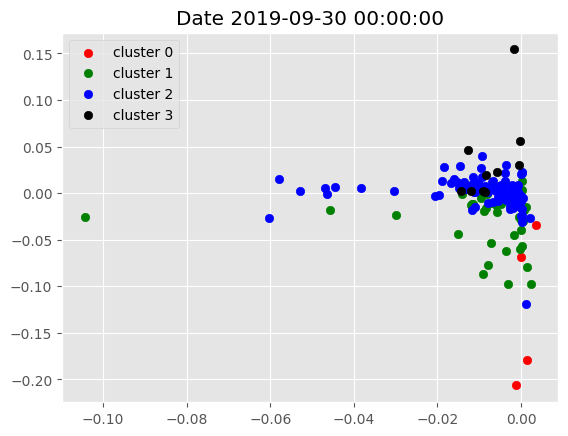

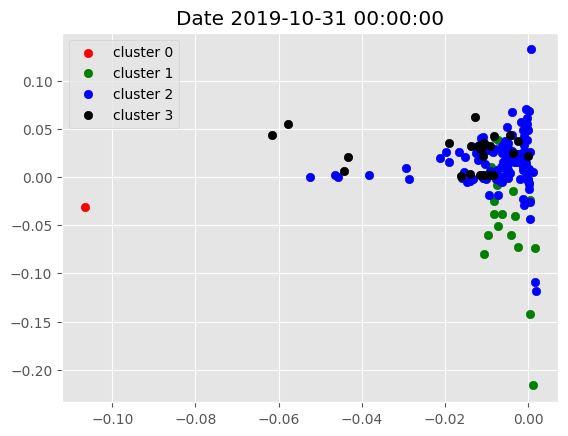

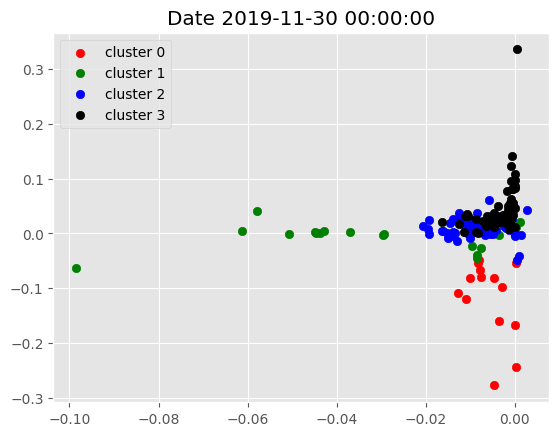

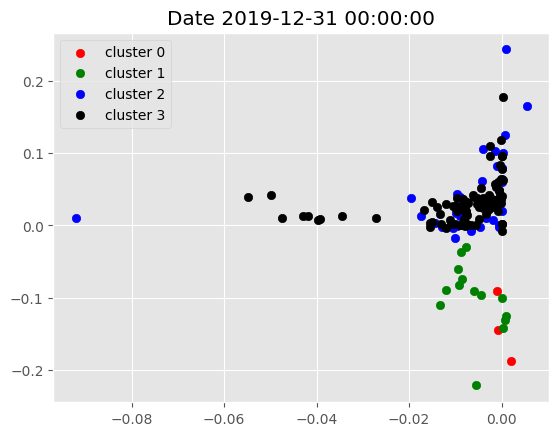

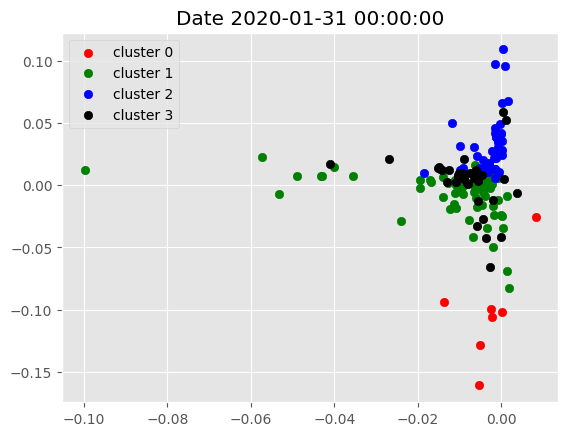

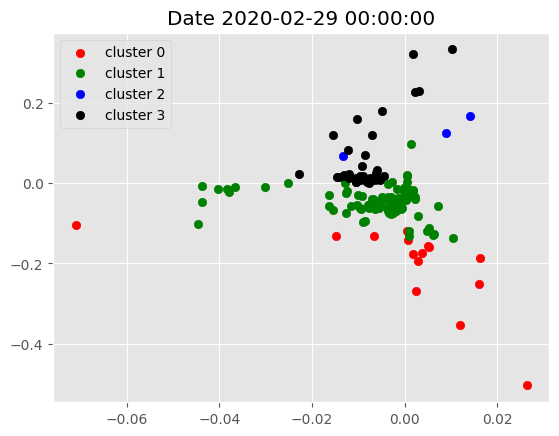

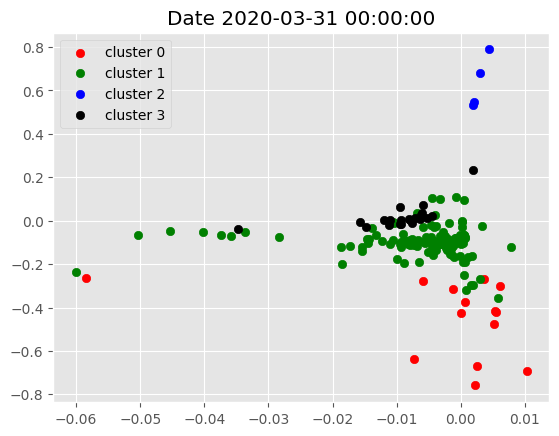

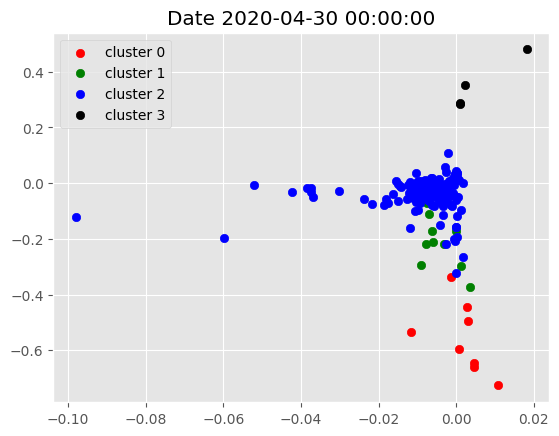

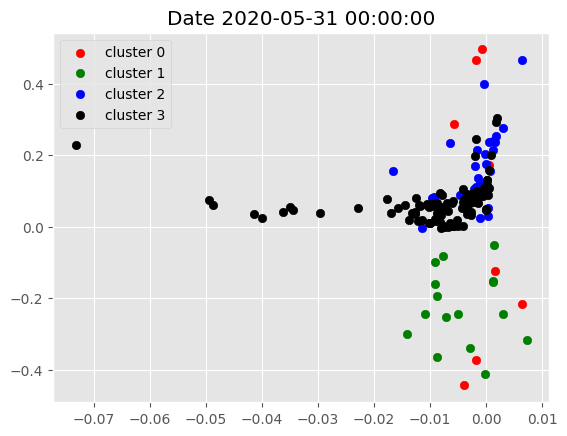

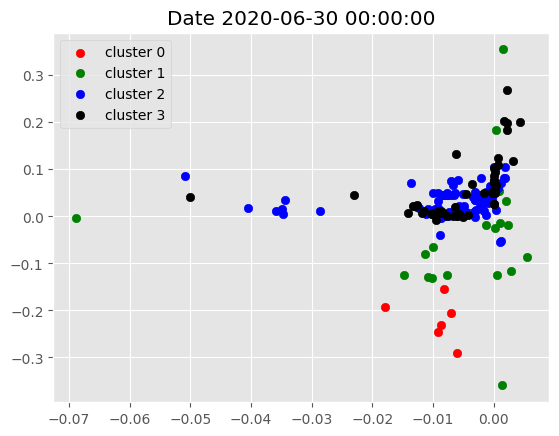

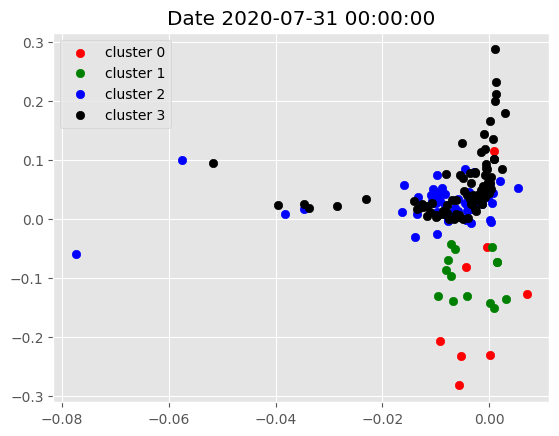

KeyboardInterrupt: 

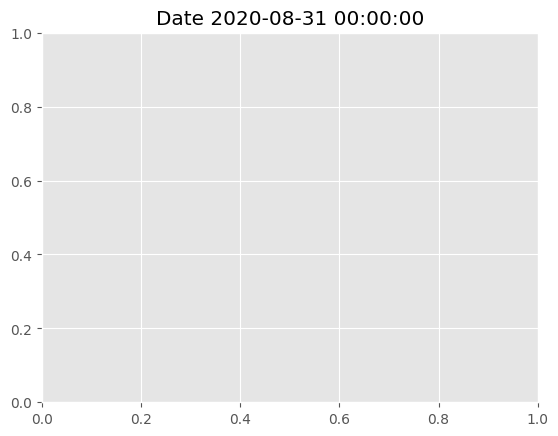

In [193]:

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

## Pick Cluster for Optimization

In [464]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [465]:
stocks = data.index.get_level_values('ticker').unique().tolist()

stock_price_per_month_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

stock_price_per_month_df

[*********************100%***********************]  166 of 166 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2016-09-30   25.948412   43.135971         NaN   35.842869  105.323631   
2016-10-03   25.826765   43.245415         NaN   36.063221  104.194260   
2016-10-04   25.936939   43.088100         NaN   35.681824  101.935555   
2016-10-05   25.948412   43.354832         NaN   36.224247  101.909691   
2016-10-06   26.141216   42.971832         NaN   36.419193  102.176926   
...                ...         ...         ...         ...         ...   
2025-09-18  237.880005  221.990005  125.470001  134.570007  239.550003   
2025-09-19  245.500000  222.470001  127.040001  136.039993  239.699997   
2025-09-22  256.079987  222.589996  125.440002  136.619995  239.990005   
2025-09-23  254.429993  222.610001  123.500000  135.889999  235.500000   
2025-09-24  251.514999  220.019897  122.785004  135.360001  238.520004   

Price                                                                  ...  \
Ticker            ADBE         ADI         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2016-09-30  108.540001   54.258156   72.901329   72.330002  47.242290  ...   
2016-10-03  108.449997   54.089794   72.430176   71.180000  46.907928  ...   
2016-10-04  108.389999   54.081364   72.049973   71.419998  47.035305  ...   
2016-10-05  108.800003   54.451790   72.388832   73.209999  47.688141  ...   
2016-10-06  108.559998   54.502289   72.372284   72.830002  47.727936  ...   
...                ...         ...         ...         ...        ...  ...   
2025-09-18  367.459991  249.050003  290.950012  323.040009  78.029999  ...   
2025-09-19  365.899994  245.330002  292.000000  322.670013  76.980003  ...   
2025-09-22  364.079987  247.339996  293.660004  324.390015  76.529999  ...   
2025-09-23  361.779999  246.779999  289.209991  324.859985  76.699997  ...   
2025-09-24  350.869995  248.675003  291.630005  323.559998  77.470001  ...   

Price        Volume                                                            \
Ticker          VLO     VRTX        VZ     WDAY       WDC       WFC       WMT   
Date                                                                            
2016-09-30  8318600  2545700  13077600  1524100   5816966  54117700  29947800   
2016-10-03  5172200  1371300   9120300  1011300   6831840  38197700  17573100   
2016-10-04  5804000  1081100  13753300  1173800   6087388  44008300  19707900   
2016-10-05  6393900   964400  17190900  1507800   5876766  40459000  19393200   
2016-10-06  4045600  1375000  11724000  1385000   6568166  29878200  60330900   
...             ...      ...       ...      ...       ...       ...       ...   
2025-09-18  2492500  1979600  16507300  4383800  10389100  13021100  14869400   
2025-09-19  8119400  3394000  29164200  5925700  11030700  36482400  34791600   
2025-09-22  2613000  1484600  18507700  4622600   9686300  14545000  12861900   
2025-09-23  4021500  1568400  16792200  3739200   7366100  14816900  13156800   
2025-09-24  1187605   570837   8321661   982635   4486130   3869735   5100457   

Price                                   
Ticker         WYNN       XOM      XYZ  
Date                                    
2016-09-30  6737900  15961500  3562400  
2016-10-03  4234900   7111200  2480400  
2016-10-04  3288400   8222000  2132100  
2016-10-05  2699600   8796200  1674600  
2016-10-06  1969200   7718300  2370600  
...             ...       ...      ...  
2025-09-18  1954200  14628700  5443800  
2025-09-19  3328100  38746500  7600300  
2025-09-22  1281400  15611500  9005300  
2025-09-23   991800  25365800  7216600  
2025-09-24   319119   5132249  2115929  

[2258 rows x 996 columns]

## Optimization

In [466]:
def robust_optimize_weights(prices, lower_bound=0.0, risk_free_rate=0.04, verbose=False):
    try:
        if len(prices) < 5:
            if verbose:
                print("⚠️ Insufficient data points, using equal weights")
            return {ticker: 1 / prices.shape[1] for ticker in prices.columns}, "equal_weights_insufficient_data"

        # --- inputs ---
        num_assets = prices.shape[1]

        # Feasibility guard: sum of lower bounds must be ≤ 1
        if lower_bound * num_assets > 1.0:
            if verbose:
                print(f"⚠️ Lower bound {lower_bound:.4f} infeasible for {num_assets} assets; using 0.0")
            lower_bound = 0.0

        # Expected returns & covariance (use shrinkage for stability)
        mu = expected_returns.mean_historical_return(prices, frequency=252)
        cov = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

        if verbose:
            print(f"Expected returns range: {mu.min():.4f} to {mu.max():.4f}")
            print(f"Risk-free rate: {risk_free_rate:.4f}")

        # Dynamic cap
        max_weight = min(0.15, 3.0 / num_assets)

        # ---- Strategy 1: Max Sharpe ----
        try:
            if mu.max() > risk_free_rate:
                ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
                ef.max_sharpe(risk_free_rate=risk_free_rate)  # don't pass solver here
                w = ef.clean_weights()
                if verbose: print("✅ Max Sharpe optimization successful")
                return w, "max_sharpe"
            else:
                raise ValueError("No assets exceed risk-free rate")
        except (OptimizationError, ValueError) as e:
            if verbose: print(f"Max Sharpe failed: {e}")

        # ---- Strategy 2: Max Sharpe with reduced RF ----
        try:
            lower_rf = min(risk_free_rate * 0.5, float(mu.max()) * 0.8)
            if mu.max() > lower_rf:
                ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
                ef.max_sharpe(risk_free_rate=lower_rf)
                w = ef.clean_weights()
                if verbose: print(f"✅ Max Sharpe with reduced RF ({lower_rf:.4f}) successful")
                return w, "max_sharpe_reduced_rf"
            else:
                raise ValueError("Still no assets exceed reduced RF")
        except (OptimizationError, ValueError):
            if verbose: print("Reduced RF also failed")

        # ---- Strategy 3: Min Vol ----
        try:
            ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
            ef.min_volatility()
            w = ef.clean_weights()
            if verbose: print("✅ Minimum volatility optimization successful")
            return w, "min_volatility"
        except OptimizationError:
            if verbose: print("Minimum volatility failed")

        # ---- Strategy 4: Relaxed bounds + Min Vol ----
        try:
            relaxed_lower = max(0.0, lower_bound * 0.5)
            relaxed_upper = min(1.0, max_weight * 1.5)
            ef = EfficientFrontier(mu, cov, weight_bounds=(relaxed_lower, relaxed_upper))
            ef.min_volatility()
            w = ef.clean_weights()
            if verbose: print("✅ Relaxed bounds minimum volatility successful")
            return w, "min_volatility_relaxed"
        except OptimizationError:
            if verbose: print("Relaxed bounds also failed")

        # ---- Strategy 5: Risk parity (inverse vol) ----
        try:
            vols = np.sqrt(np.clip(np.diag(cov), 1e-12, None))
            inv_vol = 1.0 / vols
            inv_vol /= inv_vol.sum()

            # apply bounds then renormalize
            inv_vol = np.clip(inv_vol, lower_bound, max_weight)
            inv_vol /= inv_vol.sum()
            w = dict(zip(prices.columns, inv_vol))
            if verbose: print("✅ Risk parity (inverse volatility) successful")
            return w, "risk_parity"
        except Exception:
            if verbose: print("Risk parity failed")

        # ---- Strategy 6: Return-weighted (shifted positive) ----
        try:
            # shifted positives
            adj = mu - float(mu.min()) + 0.01
            rw = (adj / adj.sum()).values  # numpy array
            rw = np.clip(rw, lower_bound, max_weight)
            rw = rw / rw.sum()
            w = dict(zip(prices.columns, rw))
            if verbose: print("✅ Adjusted return weighting successful")
            return w, "return_weighted"
        except Exception:
            if verbose: print("Return weighting failed, using equal weights")

        # ---- Final fallback ----
        eq = {t: 1 / num_assets for t in prices.columns}
        return eq, "equal_weights_final_fallback"

    except Exception as e:
        if verbose:
            print(f"Unexpected error: {e}")
        eq = {t: 1 / prices.shape[1] for t in prices.columns}
        return eq, "equal_weights_error"


In [467]:
def analyze_portfolio_weights(weights_dict, method_used, price_data=None):
    """
    Analyze portfolio weight characteristics (optional helper)
    """
    w = pd.Series(weights_dict).sort_values(ascending=False)
    print(f"\n📊 Portfolio Analysis (Method: {method_used})")
    print(f"Number of assets: {len(w)}")
    w_min = float(w.min())
    w_max = float(w.max())
    print(f"Weight range: {w_min:.4f} to {w_max:.4f}")
    denom = w_min if w_min > 1e-8 else 1e-8
    print(f"Weight concentration (max/min): {w_max/denom:.2f}")
    print(f"Effective number of stocks: {1/np.sum(w**2):.2f}")
    print("\nTop 5 weights:")
    print(w.head(5).round(4))

    if price_data is not None:
        exp_rets = expected_returns.mean_historical_return(price_data, frequency=252)
        port_mu = float((w.reindex(exp_rets.index).fillna(0) * exp_rets).sum())
        print(f"\nExpected portfolio return: {port_mu:.4f}")


In [468]:
def run_portfolio_optimization(stock_price_per_month_df, returns_dataframe, fixed_dates, lower_bound=0.012, verbose=False):
    portfolio_df = pd.DataFrame()
    optimization_results = []

    for i, start_date in enumerate(fixed_dates.keys()):
        if verbose:
            print(f"\n{'='*50}\nProcessing period {i+1}/{len(fixed_dates)}: {start_date}")

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        # price panel
        adj_close_df = stock_price_per_month_df.xs('Adj Close', axis=1, level=0)

        # 12-month lookback (exclude current month for fit)
        optimization_start = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimization_df = adj_close_df.loc[optimization_start:optimization_end, cols]

        if len(optimization_df) < 20:
            if verbose: print(f"⚠️ Insufficient data for {start_date}, skipping...")
            continue

        valid_cols = optimization_df.dropna(axis=1, thresh=int(len(optimization_df)*0.8)).columns
        if len(valid_cols) < len(cols) and verbose:
            print(f"⚠️ Removed {len(cols) - len(valid_cols)} assets due to missing data")
        optimization_df = optimization_df[valid_cols]
        cols = valid_cols.tolist()
        if not cols:
            if verbose: print(f"⚠️ No valid assets for {start_date}, skipping...")
            continue

        # get weights
        weights_dict, method_used = robust_optimize_weights(
            prices=optimization_df,
            lower_bound=lower_bound,
            verbose=verbose
        )
        if verbose:
            analyze_portfolio_weights(weights_dict, method_used, optimization_df)

        optimization_results.append({
            'date': start_date,
            'method': method_used,
            'n_assets': len(cols),
            'data_length': len(optimization_df)
        })

        # daily returns for current month
        temp_returns = returns_dataframe.loc[start_date:end_date, cols]

        temp_df = temp_returns.stack().to_frame('return')
        temp_df.index.names = ['Date', 'Ticker']

        weights = pd.Series(weights_dict, name='weight')
        temp_df = temp_df.join(weights, on='Ticker').fillna({'weight': 0.0})
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        daily_returns = temp_df.groupby(level='Date')['weighted_return'].sum().to_frame('Strategy Return')
        portfolio_df = pd.concat([portfolio_df, daily_returns], axis=0)

    portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')].sort_index()

    if verbose and optimization_results:
        print(f"\n{'='*50}\nOPTIMIZATION SUMMARY\n{'='*50}")
        methods_used = pd.DataFrame(optimization_results)['method'].value_counts()
        print("Methods used:")
        for method, count in methods_used.items():
            print(f"  {method}: {count} periods")

    return portfolio_df, optimization_results


returns_dataframe = np.log(stock_price_per_month_df['Adj Close']).diff()

portfolio_df, results = run_portfolio_optimization(
     stock_price_per_month_df,
     returns_dataframe,
     fixed_dates,
     lower_bound=0.012,
     verbose=True  # Set to False to reduce output
 )


Processing period 1/97: 2017-10-01
Expected returns range: -0.0949 to 1.6443
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

📊 Portfolio Analysis (Method: max_sharpe)
Number of assets: 44
Weight range: 0.0120 to 0.0682
Weight concentration (max/min): 5.68
Effective number of stocks: 24.86

Top 5 weights:
BA      0.0682
MAR     0.0682
ISRG    0.0682
NVDA    0.0648
ABBV    0.0647
dtype: float64

Expected portfolio return: 0.6162

Processing period 2/97: 2017-11-01
Expected returns range: 0.2066 to 2.0224
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

📊 Portfolio Analysis (Method: max_sharpe)
Number of assets: 48
Weight range: 0.0120 to 0.0625
Weight concentration (max/min): 5.21
Effective number of stocks: 30.48

Top 5 weights:
BA      0.0625
ELV     0.0625
MCD     0.0625
MAR     0.0589
ISRG    0.0474
dtype: float64

Expected portfolio return: 0.6685

Processing period 3/97: 2017-12-01
Expected returns range: -0.1208 to 0.9806
Risk-free rate: 0.0400
✅ Max Shar

#### Option 2

In [222]:
import numpy as np
import pandas as pd
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.exceptions import OptimizationError
import warnings
warnings.filterwarnings('ignore')

returns_dataframe = np.log(stock_price_per_month_df['Adj Close']).diff()

def robust_optimize_weights(prices, lower_bound=0.0, risk_free_rate=0.04, verbose=False):
    """
    Robust portfolio optimization with multiple fallback strategies

    Parameters:
    - prices: DataFrame of asset prices
    - lower_bound: minimum weight per asset
    - risk_free_rate: risk-free rate for Sharpe ratio
    - verbose: print debug information

    Returns:
    - dict: asset weights
    - str: method used for optimization
    """

    if len(prices) < 5:  # Need minimum data
        if verbose:
            print("⚠️ Insufficient data points, using equal weights")
        return {ticker: 1 / prices.shape[1] for ticker in prices.columns}, "equal_weights_insufficient_data"

    try:
        # Calculate returns and covariance
        returns = expected_returns.mean_historical_return(prices, frequency=252)
        cov = risk_models.sample_cov(prices, frequency=252)

        num_assets = prices.shape[1]

        if verbose:
            print(f"Expected returns range: {returns.min():.4f} to {returns.max():.4f}")
            print(f"Risk-free rate: {risk_free_rate:.4f}")

        # Dynamic upper bound
        max_weight = min(0.15, 1.0 / num_assets * 3)  # Allow slightly higher concentration

        # Strategy 1: Max Sharpe with original risk-free rate
        try:
            if max(returns) > risk_free_rate:
                ef = EfficientFrontier(
                    expected_returns=returns,
                    cov_matrix=cov,
                    weight_bounds=(lower_bound, max_weight),
                    solver='ECOS'  # Try ECOS first, often more reliable
                )
                ef.max_sharpe(risk_free_rate=risk_free_rate)
                weights = ef.clean_weights()
                if verbose:
                    print("✅ Max Sharpe optimization successful")
                return weights, "max_sharpe"
            else:
                raise ValueError("No assets exceed risk-free rate")

        except (OptimizationError, ValueError) as e:
            if verbose:
                print(f"Max Sharpe failed: {e}")

            # Strategy 2: Lower risk-free rate
            try:
                lower_rf = min(risk_free_rate * 0.5, max(returns) * 0.8)
                if max(returns) > lower_rf:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.max_sharpe(risk_free_rate=lower_rf)
                    weights = ef.clean_weights()
                    if verbose:
                        print(f"✅ Max Sharpe with reduced risk-free rate ({lower_rf:.4f}) successful")
                    return weights, "max_sharpe_reduced_rf"
                else:
                    raise ValueError("Still no assets exceed reduced risk-free rate")

            except (OptimizationError, ValueError):
                if verbose:
                    print("Reduced risk-free rate also failed")

                # Strategy 3: Minimum Volatility
                try:
                    ef = EfficientFrontier(
                        expected_returns=returns,
                        cov_matrix=cov,
                        weight_bounds=(lower_bound, max_weight),
                        solver='ECOS'
                    )
                    ef.min_volatility()
                    weights = ef.clean_weights()
                    if verbose:
                        print("✅ Minimum volatility optimization successful")
                    return weights, "min_volatility"

                except OptimizationError:
                    if verbose:
                        print("Minimum volatility failed")

                    # Strategy 4: Relaxed bounds
                    try:
                        relaxed_lower = max(0.0, lower_bound * 0.5)
                        relaxed_upper = min(1.0, max_weight * 1.5)

                        ef = EfficientFrontier(
                            expected_returns=returns,
                            cov_matrix=cov,
                            weight_bounds=(relaxed_lower, relaxed_upper),
                            solver='SCS'  # Try different solver
                        )
                        ef.min_volatility()
                        weights = ef.clean_weights()
                        if verbose:
                            print("✅ Relaxed bounds minimum volatility successful")
                        return weights, "min_volatility_relaxed"

                    except OptimizationError:
                        if verbose:
                            print("Relaxed bounds also failed")

                        # Strategy 5: Risk parity (inverse volatility weighting)
                        try:
                            individual_vols = np.sqrt(np.diag(cov))
                            inv_vol_weights = 1 / individual_vols
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()

                            # Apply bounds
                            inv_vol_weights = np.maximum(inv_vol_weights, lower_bound)
                            inv_vol_weights = np.minimum(inv_vol_weights, max_weight)
                            inv_vol_weights = inv_vol_weights / inv_vol_weights.sum()  # Renormalize

                            weights = dict(zip(prices.columns, inv_vol_weights))
                            if verbose:
                                print("✅ Risk parity (inverse volatility) successful")
                            return weights, "risk_parity"

                        except Exception:
                            if verbose:
                                print("Risk parity failed")

                            # Strategy 6: Return-weighted (avoid negative returns)
                            try:
                                # Shift returns to be positive
                                adjusted_returns = returns - returns.min() + 0.01
                                return_weights = adjusted_returns / adjusted_returns.sum()

                                # Apply bounds
                                return_weights = np.maximum(return_weights, lower_bound)
                                return_weights = np.minimum(return_weights, max_weight)
                                return_weights = return_weights / return_weights.sum()

                                weights = dict(zip(prices.columns, return_weights))
                                if verbose:
                                    print("✅ Adjusted return weighting successful")
                                return weights, "return_weighted"

                            except Exception:
                                if verbose:
                                    print("Return weighting failed, using equal weights")

                                # Final fallback: Equal weights
                                equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
                                return equal_weights, "equal_weights_final_fallback"

    except Exception as e:
        if verbose:
            print(f"Unexpected error: {e}")
        # Ultimate fallback
        equal_weights = {ticker: 1 / prices.shape[1] for ticker in prices.columns}
        return equal_weights, "equal_weights_error"

def analyze_portfolio_weights(weights_dict, method_used, returns_data=None):
    """
    Analyze and display portfolio weight characteristics
    """
    weights_series = pd.Series(weights_dict)

    print(f"\n📊 Portfolio Analysis (Method: {method_used})")
    print(f"Number of assets: {len(weights_series)}")
    print(f"Weight range: {weights_series.min():.4f} to {weights_series.max():.4f}")
    print(f"Weight concentration (max/min): {weights_series.max()/weights_series.min():.2f}")
    print(f"Effective number of stocks: {1/np.sum(weights_series**2):.2f}")

    # Show top 5 weights
    print(f"\nTop 5 weights:")
    print(weights_series.nlargest(5).round(4))

    if returns_data is not None:
        expected_returns = expected_returns.mean_historical_return(returns_data, frequency=252)
        portfolio_return = np.sum(weights_series * expected_returns)
        print(f"\nExpected portfolio return: {portfolio_return:.4f}")

# Updated main optimization function
def optimize_weights_robust(prices, lower_bound=0.0, verbose=False):
    """
    Main function that calls the robust optimizer
    """
    weights, method = robust_optimize_weights(
        prices=prices,
        lower_bound=lower_bound,
        verbose=verbose
    )

    if verbose:
        analyze_portfolio_weights(weights, method, prices)

    return weights

# Your updated portfolio loop
def run_portfolio_optimization(stock_price_per_month_df, returns_dataframe, fixed_dates, lower_bound=0.012, verbose=False):
    """
    Run the complete portfolio optimization loop with robust error handling
    """
    portfolio_df = pd.DataFrame()
    optimization_results = []  # Track which method was used for each period

    for i, start_date in enumerate(fixed_dates.keys()):
        if verbose:
            print(f"\n{'='*50}")
            print(f"Processing period {i+1}/{len(fixed_dates)}: {start_date}")

        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        adj_close_df = stock_price_per_month_df.xs('Adj Close', axis=1, level=0)
        optimization_df = adj_close_df.loc[optimization_start_date:optimization_end_date, cols]

        # Check data quality
        if len(optimization_df) < 20:  # Need minimum trading days
            print(f"⚠️ Insufficient data for {start_date}, skipping...")
            continue

        # Remove any columns with insufficient data
        valid_cols = optimization_df.dropna(axis=1, thresh=len(optimization_df)*0.8).columns
        if len(valid_cols) < len(cols):
            print(f"⚠️ Removed {len(cols) - len(valid_cols)} assets due to missing data")
            optimization_df = optimization_df[valid_cols]
            cols = valid_cols.tolist()

        if len(cols) == 0:
            print(f"⚠️ No valid assets for {start_date}, skipping...")
            continue

        # Get robust weights
        weights_dict, method_used = robust_optimize_weights(
            prices=optimization_df,
            lower_bound=lower_bound,
            verbose=verbose
        )

        optimization_results.append({
            'date': start_date,
            'method': method_used,
            'n_assets': len(cols),
            'data_length': len(optimization_df)
        })

        # Convert weights dict to DataFrame
        weights = pd.Series(weights_dict).to_frame('weight')

        # Slice returns for this period
        temp_returns = returns_dataframe.loc[start_date:end_date, cols]

        # Reshape and merge returns and weights
        temp_df = temp_returns.stack().to_frame('return')
        temp_df.index.names = ['Date', 'Ticker']

        # Join weights
        temp_df = temp_df.join(weights, on='Ticker')
        temp_df['weight'] = temp_df['weight'].fillna(0)  # Handle missing weights

        # Compute weighted returns
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']

        # Sum by day to get portfolio return
        daily_returns = temp_df.groupby(level='Date')['weighted_return'].sum().to_frame('Strategy Return')

        # Append to full portfolio
        portfolio_df = pd.concat([portfolio_df, daily_returns], axis=0)

    # Remove duplicate index entries
    portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')]

    # Print optimization summary
    if verbose:
        print(f"\n{'='*50}")
        print("OPTIMIZATION SUMMARY")
        print(f"{'='*50}")
        methods_used = pd.DataFrame(optimization_results)['method'].value_counts()
        print("Methods used:")
        for method, count in methods_used.items():
            print(f"  {method}: {count} periods")

    return portfolio_df, optimization_results

 #Usage example:
portfolio_df, results = run_portfolio_optimization(
     stock_price_per_month_df,
     returns_dataframe,
     fixed_dates,
     lower_bound=0.012,
     verbose=True  # Set to False to reduce output
 )


Processing period 1/73: 2019-10-01
Expected returns range: -0.2369 to 0.4344
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 2/73: 2019-11-01
Expected returns range: -0.1759 to 0.8366
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 3/73: 2019-12-01
Expected returns range: -0.1119 to 0.7956
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 4/73: 2020-01-01
Expected returns range: 0.0932 to 1.4441
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 5/73: 2020-02-01
Expected returns range: 0.0552 to 1.0899
Risk-free rate: 0.0400
✅ Max Sharpe optimization successful

Processing period 6/73: 2020-03-01
Expected returns range: 0.0114 to 0.0114
Risk-free rate: 0.0400
Max Sharpe failed: No assets exceed risk-free rate
Reduced risk-free rate also failed
Minimum volatility failed
Relaxed bounds also failed
✅ Risk parity (inverse volatility) successful

Processing period 7/73: 20

## Graphing Comparison

In [469]:
spy = yf.download(tickers='SPY',
                  start='2017-01-01',
                  end=dt.date.today(), auto_adjust=False)

# Flatten the multi-level index of spy_ret to a single level ('Date')
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1).droplevel(level=1, axis=1)


portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
Date,,
2017-10-02,0.004770,0.004329
2017-10-03,0.001980,0.002138
2017-10-04,-0.000426,0.001186
2017-10-05,0.008537,0.005908
2017-10-06,0.002519,-0.001139
...,...,...
2025-09-17,0.002251,-0.001243
2025-09-18,0.004724,0.004662
2025-09-19,0.001276,0.004941


In [ ]:
weekly_df = portfolio_df.copy()  # DONT RUN
weekly_df

,Strategy Return,SPY Buy&Hold
Date,,
2017-01-04,0.073434,0.005932
2017-01-05,-0.014262,-0.000795
2017-01-06,0.018971,0.003571
2017-01-09,-0.014875,-0.003306
2017-01-10,0.057575,0.000000
...,...,...
2025-09-15,-0.008606,0.005310
2025-09-16,-0.001281,-0.001378
2025-09-17,-0.000321,-0.001243


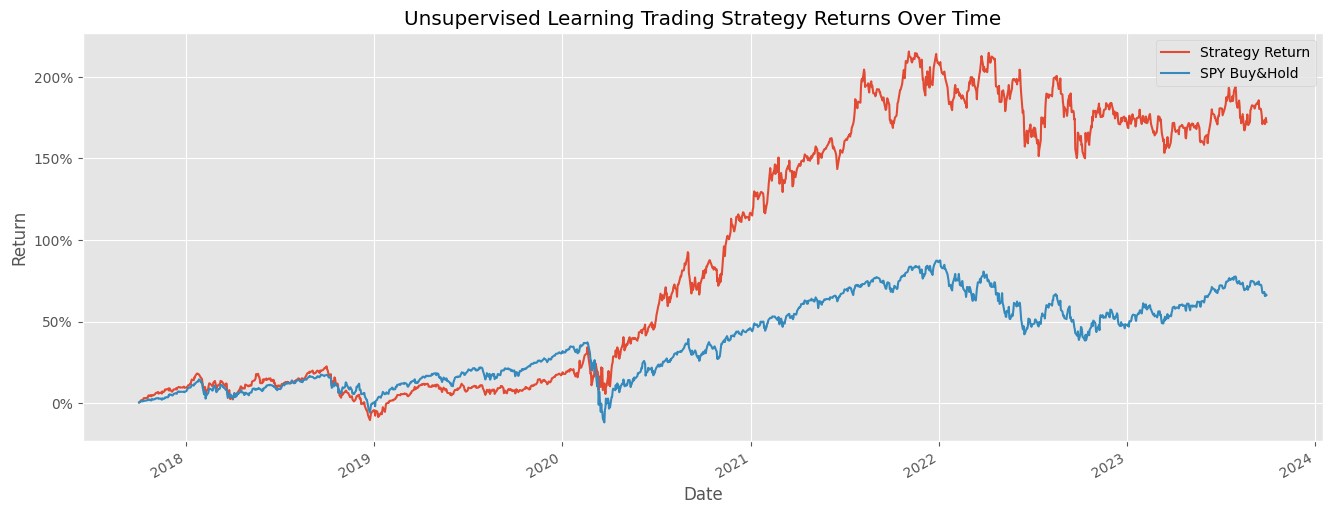

In [470]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

<Axes: xlabel='Date'>

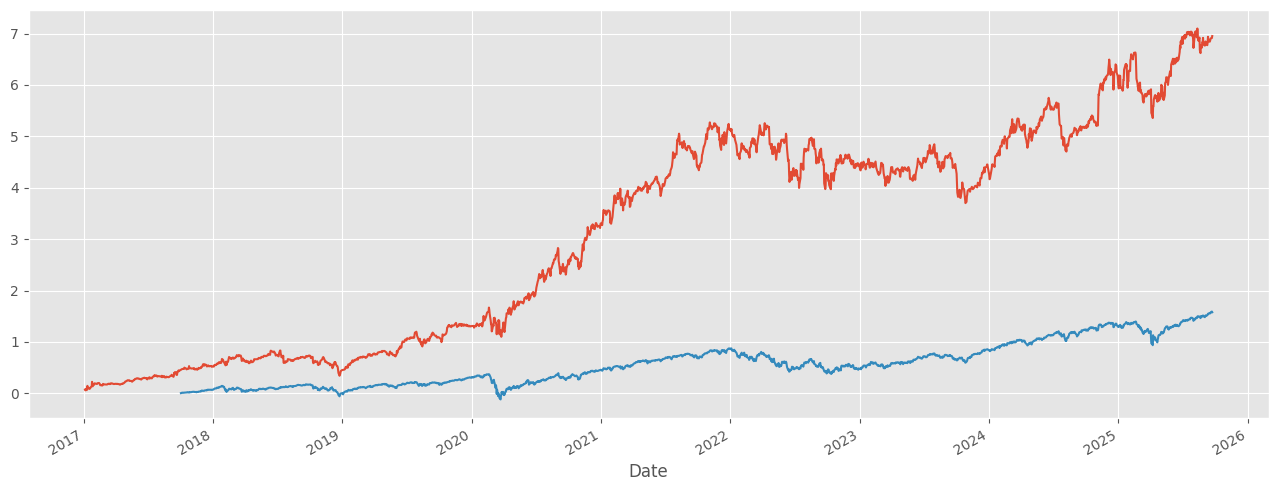

In [480]:
# split weekly_df at 2020 and merge with portfolio_df at 2020
train1 = weekly_df[:'2020-02-01']['Strategy Return']
train2 = portfolio_df['2020-02-01':]['Strategy Return']
train1[-5:], train2[:5]
train = pd.concat([train1, train2])
train_cumulative_return = np.exp(np.log1p(train).cumsum())-1
train_cumulative_return.plot(figsize=(16,6))
# add the spy cumulative return
spy_cumulative_return = np.exp(np.log1p(portfolio_df['SPY Buy&Hold']).cumsum())-1
spy_cumulative_return.plot(figsize=(16,6))

In [482]:
train

Date
2017-01-04    0.073434
2017-01-05   -0.014262
2017-01-06    0.018971
2017-01-09   -0.014875
2017-01-10    0.057575
                ...   
2025-09-17    0.002251
2025-09-18    0.004724
2025-09-19    0.001276
2025-09-22    0.000694
2025-09-23    0.004847
Name: Strategy Return, Length: 2144, dtype: float64

Strategy ROI: 695.04%
Benchmark ROI: 157.73%


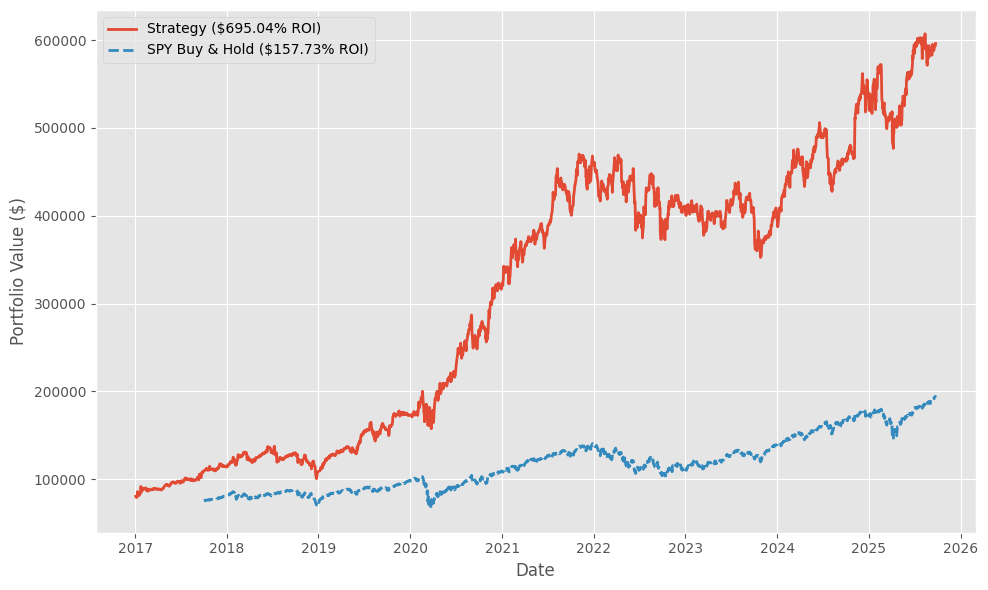

In [483]:
gross_rets = (1+train).cumprod()
bench_rets = (1+portfolio_df['SPY Buy&Hold']).cumprod()

initial_investment = 75_000
rets = gross_rets * initial_investment
b_rets = bench_rets * initial_investment

# Calculate ROI
roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100

# Print ROI
print(f"Strategy ROI: {roi:.2f}%")
print(f"Benchmark ROI: {b_roi:.2f}%")

# Plot both investment values
plt.figure(figsize=(10, 6))
plt.plot(rets, label=f'Strategy (${roi:.2f}% ROI)', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)

#plt.title('Value of $1000 Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [481]:
gross_rets = (1+portfolio_df['Strategy Return']).cumprod()
bench_rets = (1+portfolio_df['SPY Buy&Hold']).cumprod()

rets = (gross_rets * 1000)
roi = ((rets[-1] - 1000)/1000) * 100
roi

b_rets = (bench_rets * 1000)
b_roi = ((b_rets[-1] - 1000)/1000) * 100
b_roi, roi, rets[-1]

(np.float64(157.72562355339176),
 np.float64(299.89294856251166),
 np.float64(3998.9294856251167))

In [313]:
portfolio_df['Strategy Return'].mean(), portfolio_df['SPY Buy&Hold'].mean()

(np.float64(0.000817229181038695), np.float64(0.0005484408260588553))

Strategy ROI: 90.51%
Benchmark ROI: 193.18%


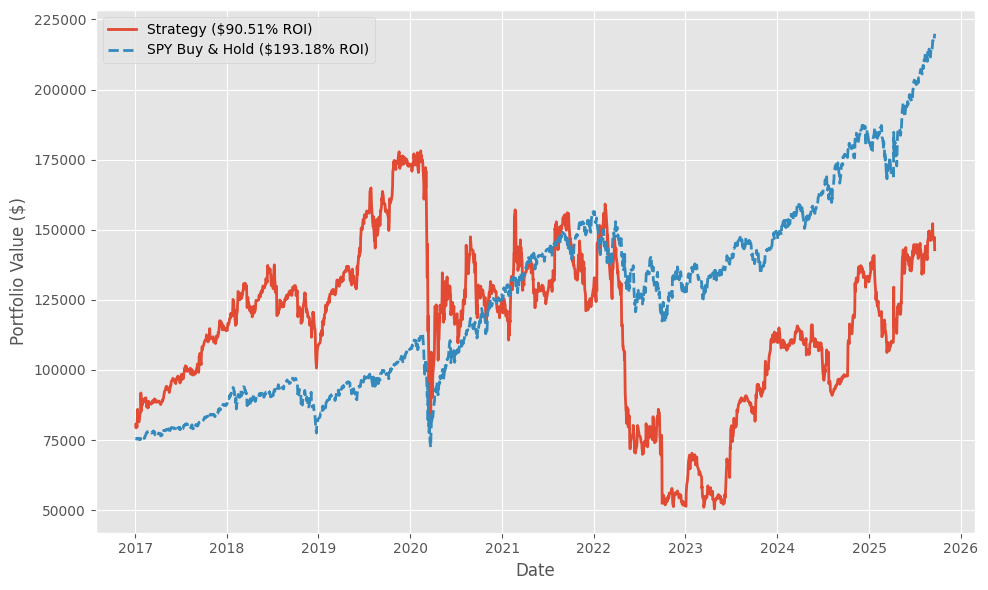

In [454]:
import matplotlib.pyplot as plt

# Calculate cumulative returns
gross_rets = (1 + portfolio_df['Strategy Return']).cumprod()
bench_rets = (1 + portfolio_df['SPY Buy&Hold']).cumprod()

# Calculate investment values starting with $1000
initial_investment = 75_000
rets = gross_rets * initial_investment
b_rets = bench_rets * initial_investment

# Calculate ROI
roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100

# Print ROI
print(f"Strategy ROI: {roi:.2f}%")
print(f"Benchmark ROI: {b_roi:.2f}%")

# Plot both investment values
plt.figure(figsize=(10, 6))
plt.plot(rets, label=f'Strategy (${roi:.2f}% ROI)', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)

#plt.title('Value of $1000 Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


swam with dog
cooked today
stock algo
run 
banking interview

PORTFOLIO PERFORMANCE ANALYSIS

📈 RETURN METRICS
Metric                    Strategy        Benchmark       Difference     
----------------------------------------------------------------------
Total ROI                 217468204.69%       157.73% 217468046.97%
Annualized Return               440.23%        12.64%       427.60%
Final Value               $2,174,683,047 $      2,577 $2,174,680,470

⚠️  RISK METRICS
Volatility                       30.41%        19.42%
Max Drawdown                    -24.32%       -35.75%
Downside Deviation               20.20%        16.40%
VaR (95%)                        -1.65%        -1.81%
CVaR (95%)                       -2.91%        -3.02%

📊 RISK-ADJUSTED METRICS
Sharpe Ratio                    14.412        0.548
Sortino Ratio                   21.700        0.649
Calmar Ratio                    18.099        0.353
Information Ratio               17.834

🏛️  GREEK LETTERS
Alpha (annual)                  428.24%
Beta                             0

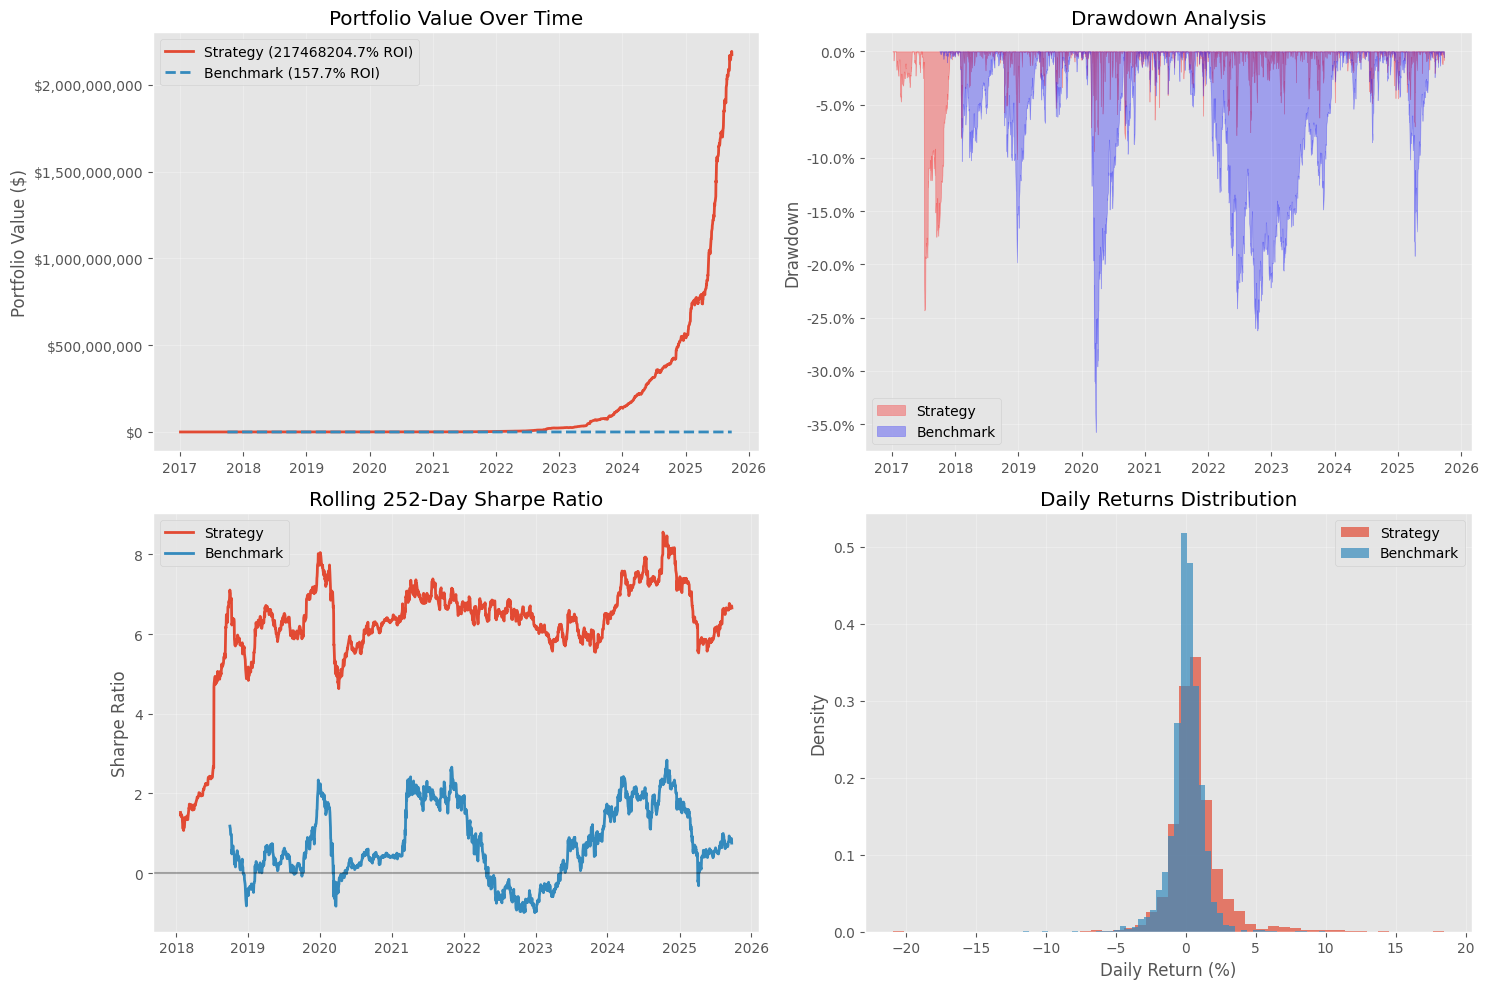

In [554]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

def calculate_performance_metrics(returns, benchmark_returns=None, risk_free_rate=0.02):
    """
    Calculate comprehensive performance metrics for a returns series
    
    Parameters:
    -----------
    returns : pd.Series
        Daily returns series
    benchmark_returns : pd.Series, optional
        Benchmark returns for comparison
    risk_free_rate : float
        Annual risk-free rate (default 2%)
    
    Returns:
    --------
    dict : Dictionary containing all performance metrics
    """
    
    # Convert to daily risk-free rate
    rf_daily = risk_free_rate / 252
    
    # Basic return metrics
    total_return = (1 + returns).prod() - 1
    periods = len(returns)
    annualized_return = (1 + total_return) ** (252 / periods) - 1
    
    # Risk metrics
    volatility = returns.std() * np.sqrt(252)
    downside_returns = returns[returns < rf_daily]
    downside_deviation = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    
    # Risk-adjusted returns
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
    sortino_ratio = (annualized_return - risk_free_rate) / downside_deviation if downside_deviation > 0 else 0
    
    # Drawdown analysis
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdown = (cumulative - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Find max drawdown period
    max_dd_end = drawdown.idxmin()
    max_dd_start = cumulative.loc[:max_dd_end].idxmax()
    max_dd_duration = (max_dd_end - max_dd_start).days
    
    # Recovery analysis
    recovery_dates = []
    in_drawdown = False
    drawdown_start = None
    
    for date in drawdown.index:
        if drawdown[date] < -0.005 and not in_drawdown:  # 0.5% threshold
            in_drawdown = True
            drawdown_start = date
        elif drawdown[date] >= -0.001 and in_drawdown:  # Recovery threshold
            in_drawdown = False
            if drawdown_start:
                recovery_dates.append((date - drawdown_start).days)
    
    avg_recovery_time = np.mean(recovery_dates) if recovery_dates else 0
    
    # Additional metrics
    win_rate = (returns > 0).mean()
    loss_rate = (returns < 0).mean()
    avg_win = returns[returns > 0].mean() if (returns > 0).any() else 0
    avg_loss = returns[returns < 0].mean() if (returns < 0).any() else 0
    profit_factor = abs(avg_win * win_rate / avg_loss) if avg_loss != 0 else np.inf
    
    # Skewness and Kurtosis
    skewness = stats.skew(returns)
    kurtosis = stats.kurtosis(returns)
    
    # VaR and CVaR (95% confidence)
    var_95 = np.percentile(returns, 5)
    cvar_95 = returns[returns <= var_95].mean()
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    metrics = {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Max Drawdown Duration (days)': max_dd_duration,
        'Average Recovery Time (days)': avg_recovery_time,
        'Win Rate': win_rate,
        'Loss Rate': loss_rate,
        'Average Win': avg_win,
        'Average Loss': avg_loss,
        'Profit Factor': profit_factor,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'VaR (95%)': var_95,
        'CVaR (95%)': cvar_95,
        'Calmar Ratio': calmar_ratio,
        'Downside Deviation': downside_deviation
    }
    
    # Benchmark comparison if provided
    if benchmark_returns is not None:
        bench_total = (1 + benchmark_returns).prod() - 1
        bench_annual = (1 + bench_total) ** (252 / len(benchmark_returns)) - 1
        bench_vol = benchmark_returns.std() * np.sqrt(252)
        
        # Tracking metrics
        
        # Beta calculation
        aligned_returns, aligned_bench = returns.align(benchmark_returns, join='inner')
        tracking_error = (aligned_returns - aligned_bench).std() * np.sqrt(252)
        information_ratio = (annualized_return - bench_annual) / tracking_error if tracking_error > 0 else 0
        
        covariance = np.cov(aligned_returns, aligned_bench)[0, 1]
        beta = covariance / np.var(aligned_bench)
        alpha = annualized_return - (risk_free_rate + beta * (bench_annual - risk_free_rate))
        
        # Up/Down capture
        up_periods = aligned_bench > rf_daily
        down_periods = aligned_bench < rf_daily
        up_capture = (aligned_returns[up_periods].mean() / aligned_bench[up_periods].mean()) if up_periods.any() else 0
        down_capture = (aligned_returns[down_periods].mean() / aligned_bench[down_periods].mean()) if down_periods.any() else 0
        
        metrics.update({
            'Alpha': alpha,
            'Beta': beta,
            'Tracking Error': tracking_error,
            'Information Ratio': information_ratio,
            'Up Capture Ratio': up_capture,
            'Down Capture Ratio': down_capture,
            'Outperformance': annualized_return - bench_annual
        })
    
    return metrics

def analyze_portfolio_performance(train_returns, benchmark_returns, initial_investment=1000, risk_free_rate=0.02):
    """
    Comprehensive portfolio performance analysis with visualization
    
    Parameters:
    -----------
    train_returns : pd.Series
        Strategy daily returns
    benchmark_returns : pd.Series  
        Benchmark daily returns
    initial_investment : float
        Starting portfolio value
    risk_free_rate : float
        Annual risk-free rate
    """
    
    # Calculate cumulative returns
    gross_rets = (1 + train_returns).cumprod()
    bench_rets = (1 + benchmark_returns).cumprod()
    
    # Calculate portfolio values
    rets = gross_rets * initial_investment
    b_rets = bench_rets * initial_investment
    
    # Calculate metrics
    strategy_metrics = calculate_performance_metrics(train_returns, benchmark_returns, risk_free_rate)
    benchmark_metrics = calculate_performance_metrics(benchmark_returns, risk_free_rate=risk_free_rate)
    
    # Display results
    print("="*80)
    print("PORTFOLIO PERFORMANCE ANALYSIS")
    print("="*80)
    
    # Basic Returns
    print(f"\n📈 RETURN METRICS")
    print(f"{'Metric':<25} {'Strategy':<15} {'Benchmark':<15} {'Difference':<15}")
    print("-"*70)
    
    roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
    b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100
    
    print(f"{'Total ROI':<25} {roi:>12.2f}% {b_roi:>12.2f}% {roi-b_roi:>12.2f}%")
    print(f"{'Annualized Return':<25} {strategy_metrics['Annualized Return']*100:>12.2f}% {benchmark_metrics['Annualized Return']*100:>12.2f}% {strategy_metrics['Outperformance']*100:>12.2f}%")
    print(f"{'Final Value':<25} ${rets.iloc[-1]:>11,.0f} ${b_rets.iloc[-1]:>11,.0f} ${rets.iloc[-1]-b_rets.iloc[-1]:>11,.0f}")
    
    # Risk Metrics
    print(f"\n⚠️  RISK METRICS")
    print(f"{'Volatility':<25} {strategy_metrics['Volatility']*100:>12.2f}% {benchmark_metrics['Volatility']*100:>12.2f}%")
    print(f"{'Max Drawdown':<25} {strategy_metrics['Max Drawdown']*100:>12.2f}% {benchmark_metrics['Max Drawdown']*100:>12.2f}%")
    print(f"{'Downside Deviation':<25} {strategy_metrics['Downside Deviation']*100:>12.2f}% {benchmark_metrics['Downside Deviation']*100:>12.2f}%")
    print(f"{'VaR (95%)':<25} {strategy_metrics['VaR (95%)']*100:>12.2f}% {benchmark_metrics['VaR (95%)']*100:>12.2f}%")
    print(f"{'CVaR (95%)':<25} {strategy_metrics['CVaR (95%)']*100:>12.2f}% {benchmark_metrics['CVaR (95%)']*100:>12.2f}%")
    
    # Risk-Adjusted Returns
    print(f"\n📊 RISK-ADJUSTED METRICS")
    print(f"{'Sharpe Ratio':<25} {strategy_metrics['Sharpe Ratio']:>12.3f} {benchmark_metrics['Sharpe Ratio']:>12.3f}")
    print(f"{'Sortino Ratio':<25} {strategy_metrics['Sortino Ratio']:>12.3f} {benchmark_metrics['Sortino Ratio']:>12.3f}")
    print(f"{'Calmar Ratio':<25} {strategy_metrics['Calmar Ratio']:>12.3f} {benchmark_metrics['Calmar Ratio']:>12.3f}")
    print(f"{'Information Ratio':<25} {strategy_metrics['Information Ratio']:>12.3f}")
    
    # Greek Letters
    print(f"\n🏛️  GREEK LETTERS")
    print(f"{'Alpha (annual)':<25} {strategy_metrics['Alpha']*100:>12.2f}%")
    print(f"{'Beta':<25} {strategy_metrics['Beta']:>12.3f}")
    print(f"{'Tracking Error':<25} {strategy_metrics['Tracking Error']*100:>12.2f}%")
    
    # Win/Loss Analysis
    print(f"\n🎯 WIN/LOSS ANALYSIS")
    print(f"{'Win Rate':<25} {strategy_metrics['Win Rate']*100:>12.2f}% {benchmark_metrics['Win Rate']*100:>12.2f}%")
    print(f"{'Average Win':<25} {strategy_metrics['Average Win']*100:>12.2f}% {benchmark_metrics['Average Win']*100:>12.2f}%")
    print(f"{'Average Loss':<25} {strategy_metrics['Average Loss']*100:>12.2f}% {benchmark_metrics['Average Loss']*100:>12.2f}%")
    print(f"{'Profit Factor':<25} {strategy_metrics['Profit Factor']:>12.2f} {benchmark_metrics['Profit Factor']:>12.2f}")
    
    # Distribution Analysis
    print(f"\n📈 DISTRIBUTION ANALYSIS")
    print(f"{'Skewness':<25} {strategy_metrics['Skewness']:>12.3f} {benchmark_metrics['Skewness']:>12.3f}")
    print(f"{'Kurtosis':<25} {strategy_metrics['Kurtosis']:>12.3f} {benchmark_metrics['Kurtosis']:>12.3f}")
    
    # Capture Ratios
    print(f"\n📈 CAPTURE RATIOS")
    print(f"{'Up Capture':<25} {strategy_metrics['Up Capture Ratio']*100:>12.2f}%")
    print(f"{'Down Capture':<25} {strategy_metrics['Down Capture Ratio']*100:>12.2f}%")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Portfolio value over time
    axes[0, 0].plot(rets.index, rets.values, label=f'Strategy ({roi:.1f}% ROI)', linewidth=2)
    axes[0, 0].plot(b_rets.index, b_rets.values, label=f'Benchmark ({b_roi:.1f}% ROI)', linewidth=2, linestyle='--')
    axes[0, 0].set_title('Portfolio Value Over Time')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Drawdown chart
    strategy_cum = (1 + train_returns).cumprod()
    strategy_dd = (strategy_cum / strategy_cum.expanding().max() - 1)
    
    benchmark_cum = (1 + benchmark_returns).cumprod()
    benchmark_dd = (benchmark_cum / benchmark_cum.expanding().max() - 1)
    
    axes[0, 1].fill_between(strategy_dd.index, strategy_dd.values, 0, alpha=0.3, color='red', label='Strategy')
    axes[0, 1].fill_between(benchmark_dd.index, benchmark_dd.values, 0, alpha=0.3, color='blue', label='Benchmark')
    axes[0, 1].set_title('Drawdown Analysis')
    axes[0, 1].set_ylabel('Drawdown')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1%}'))
    
    # Rolling Sharpe ratio (252-day window)
    rolling_sharpe_strategy = (train_returns.rolling(252).mean() * 252 - risk_free_rate) / (train_returns.rolling(252).std() * np.sqrt(252))
    rolling_sharpe_benchmark = (benchmark_returns.rolling(252).mean() * 252 - risk_free_rate) / (benchmark_returns.rolling(252).std() * np.sqrt(252))
    
    axes[1, 0].plot(rolling_sharpe_strategy.index, rolling_sharpe_strategy.values, label='Strategy', linewidth=2)
    axes[1, 0].plot(rolling_sharpe_benchmark.index, rolling_sharpe_benchmark.values, label='Benchmark', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 0].set_title('Rolling 252-Day Sharpe Ratio')
    axes[1, 0].set_ylabel('Sharpe Ratio')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Returns distribution
    axes[1, 1].hist(train_returns * 100, bins=50, alpha=0.7, label='Strategy', density=True)
    axes[1, 1].hist(benchmark_returns * 100, bins=50, alpha=0.7, label='Benchmark', density=True)
    axes[1, 1].set_title('Daily Returns Distribution')
    axes[1, 1].set_xlabel('Daily Return (%)')
    axes[1, 1].set_ylabel('Density')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return strategy_metrics, benchmark_metrics

# Usage example:
# Assuming you have train (strategy returns) and portfolio_df['SPY Buy&Hold'] (benchmark returns)
best_rets = pd.concat([weekly_results['cluster 3'], all_results['cluster 3']],axis=1).max(axis=1).to_frame('Strategy Return')
best_rets = (1 + best_rets['Strategy Return']).cumprod()


strategy_metrics, benchmark_metrics = analyze_portfolio_performance(
     train_returns = pd.concat([weekly_results['cluster 3'], all_results['cluster 3']],axis=1).max(axis=1).to_frame('Strategy Return')['Strategy Return'],  # Your strategy returns
     benchmark_returns=portfolio_df['SPY Buy&Hold'],  # Your benchmark returns  
     initial_investment=1_000,
     risk_free_rate=0.02  # 2% annual risk-free rate
 )

## Full Code:

In [ ]:
from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pypfopt import EfficientFrontier, expected_returns, risk_models
from pypfopt.exceptions import OptimizationError
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta as ta
import warnings
import requests
warnings.filterwarnings('ignore')


class DataCollector:
    def __init__(self):
        pass

    def fetch_data(self):
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
        }

        response = requests.get(url, headers=headers)

        response.raise_for_status()

        sp500 = pd.read_html(response.text)[0]


        sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')


        symbol_list = sp500['Symbol'].unique().tolist()


        end_date = pd.Timestamp.now().date()
        start_date = pd.to_datetime(end_date) - pd.DateOffset(years=10)

        df = yf.download(tickers=symbol_list,
                        start=start_date,
                        end=end_date, auto_adjust=False).stack()

        df.index.names = ['date', 'ticker']
        df.columns = df.columns.str.lower()
        return df



class DataPrep:
    def __init__(self):
        pass
    
    def compute_bb(self, group, key):
        bb = ta.bbands(close = group['adj close'], length=20)
        return bb.iloc[:,key]

    def compute_atr(self, group):
        atr = ta.atr(group['high'], group['low'], group['close'], length=14)
        return atr

    def compute_macd(self, group):
        macd_line = ta.macd(group, length=20).iloc[:, 0]
        return macd_line
    
    def calculate_returns(self, data):
        outlier_cutoff = 0.005

        lags = [1,2,3,6,9,12]

        for lag in lags:
            data[f'return_{lag}m'] = (data['adj close']
                                    .pct_change(lag)
                                    .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                        upper=x.quantile(1-outlier_cutoff)))
                                    .add(1)
                                    .pow(1/lag)
                                    .sub(1))
        return data
    
    def fff_betas(self, data, interval):
        factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

        factor_data.index = factor_data.index.to_timestamp()

        factor_data = factor_data.resample(interval).last().div(100)

        factor_data.index.name = 'date'

        factor_data = factor_data.join(data['return_1m']).sort_index()

        observations = factor_data.groupby('ticker').size()

        valid_stocks = observations[observations >= 10]

        factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

        betas = (factor_data.groupby('ticker', group_keys=False)
                    .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                                exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                                window=min(24, x.shape[0]),
                                                min_nobs=len(x.columns)+1)
                    .fit(params_only=True)
                    .params.drop('const', axis=1)))
        factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

        data = (data.join(betas.groupby('ticker').shift()))

        data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

        data = data.drop(['adj close','dollar_volume'], axis=1)

        data = data.dropna()
        return data

    
    def calculate_features(self, df, interval):
        df['garman_klass_vol'] = (
            ((np.log(df['high']) - np.log(df['low'])) ** 2) / 2
            - (2 * np.log(2) - 1) * (np.log(df['adj close']) - np.log(df['open'])) ** 2)
        
        df['rsi'] = df.groupby('ticker')['adj close'].transform(lambda x: ta.rsi(x, length=20))

        df['bb_low'] = df.groupby('ticker', group_keys=False).apply(self.compute_bb, 0)
        df['bb_mid'] = df.groupby('ticker', group_keys=False).apply(self.compute_bb, 1)
        df['bb_high'] = df.groupby('ticker', group_keys=False).apply(self.compute_bb, 2)
        df['bb_position'] = ((df['adj close'] - df['bb_low']) / (df['bb_high'] - df['bb_low']))
        df.drop(['bb_low', 'bb_mid', 'bb_high'], axis=1, inplace=True)

        df['atr'] = df.groupby('ticker', group_keys=False).apply(self.compute_atr)

        df['macd'] = df.groupby('ticker')['adj close'].transform(self.compute_macd)

        df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6
        
        last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
        data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample(interval).mean().stack('ticker').to_frame('dollar_volume'),
                        df.unstack()[last_cols].resample(interval).last().stack('ticker')],axis=1)).dropna()

        data['dollar_volume'] = data['dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()
        data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)
        data = data[data['dollar_vol_rank'] < 150].drop(columns=['dollar_vol_rank'],axis=1)

        data = data.groupby('ticker', group_keys=False).apply(self.calculate_returns).dropna()

        data = self.fff_betas(data, interval)

        return data
    


class Clustering:
    def __init__(self):
        pass

    def get_clusters(self, month_df: pd.DataFrame):
        TARGET_RSI_RAW = [30, 45, 55, 70] 
        numeric_cols = month_df.select_dtypes(include=[np.number]).columns.tolist()

        X = month_df[numeric_cols].copy()

        scaler = StandardScaler()
        X_scaled = pd.DataFrame(
            scaler.fit_transform(X),
            index=X.index,
            columns=numeric_cols
        )

        rsi_idx = numeric_cols.index('rsi')
        rsi_mean = scaler.mean_[rsi_idx]
        rsi_std  = scaler.scale_[rsi_idx]

        if np.isclose(rsi_std, 0.0):
            # degenerate case: no dispersion in RSI this month
            rsi_targets_z = [0.0] * len(TARGET_RSI_RAW)
        else:
            rsi_targets_z = [(t - rsi_mean) / rsi_std for t in TARGET_RSI_RAW]


        n_features = len(numeric_cols)
        initial_centroids = np.zeros((len(rsi_targets_z), n_features))
        initial_centroids[:, rsi_idx] = rsi_targets_z

        km = KMeans(
            n_clusters=len(TARGET_RSI_RAW),
            init=initial_centroids,
            n_init=1,            
            random_state=0
        )
        labels = km.fit_predict(X_scaled)

        output = month_df.copy()
        output['cluster'] = labels
        return output
    
    def run_clustering(self, data, cluster):
        data = (data.dropna().groupby('date', group_keys=False).apply(self.get_clusters))

        filtered_df = data[data['cluster']==cluster].copy()

        filtered_df = filtered_df.reset_index(level=1)

        filtered_df.index = filtered_df.index+pd.DateOffset(1)

        filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

        dates = filtered_df.index.get_level_values('date').unique().tolist()

        fixed_dates = {}

        for d in dates:

            fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

        stocks = data.index.get_level_values('ticker').unique().tolist()

        stock_price_per_month_df = yf.download(tickers=stocks,
                            start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                            end=data.index.get_level_values('date').unique()[-1], auto_adjust=False)

        return fixed_dates, stock_price_per_month_df



class ClusterResult:
    def __init__(self, cluster_id, portfolio_df, results):
        self.cluster_id = cluster_id
        self.portfolio_df = portfolio_df
        self.results = results

    def summary(self):
        rets = self.portfolio_df["Strategy Return"]
        np.exp(np.log1p(rets).cumsum())-1
        return pd.DataFrame({"cluster f'{self.cluster_id}'": rets})



class PortfolioOptimizer:
    def __init__(self):
        self.data_collector = DataCollector()
        self.data_prep = DataPrep()
        self.clustering = Clustering()

    def analyze_portfolio_weights(self, weights_dict, method_used, optimization_df):
            w = pd.Series(weights_dict).sort_values(ascending=False)
            print(f"\n📊 Portfolio Analysis (Method: {method_used})")
            print(f"Number of assets: {len(w)}")
            w_min = float(w.min())
            w_max = float(w.max())
            print(f"Weight range: {w_min:.4f} to {w_max:.4f}")
            denom = w_min if w_min > 1e-8 else 1e-8
            print(f"Weight concentration (max/min): {w_max/denom:.2f}")
            print(f"Effective number of stocks: {1/np.sum(w**2):.2f}")
            print("\nTop 5 weights:")
            print(w.head(5).round(4))
            exp_rets = expected_returns.mean_historical_return(optimization_df, frequency=252)
            port_mu = float((w.reindex(exp_rets.index).fillna(0) * exp_rets).sum())
            print(f"\nExpected portfolio return: {port_mu:.4f}")

    def optimize_weights(self, optimization_prices_df, lower_bound = 0, risk_free_rate=0.04, verbose=False):
        num_assets = optimization_prices_df.shape[1]

        mu = expected_returns.mean_historical_return(optimization_prices_df, frequency=252) 
        cov = risk_models.CovarianceShrinkage(optimization_prices_df).ledoit_wolf()

        max_weight = min(0.15, 3.0 / num_assets)

        #   ---- Strategy 1: Max Sharpe Ratio ----   #
        try: 
            if mu.max() > risk_free_rate:
                ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
                ef.max_sharpe(risk_free_rate=risk_free_rate)
                weights = ef.clean_weights()
                if verbose:
                    print("Optimization successful using Max Sharpe Ratio.")
                    return weights, 'Max Sharpe Ratio'
                else:
                    raise ValueError("No assets exceed the risk-free rate.")           
        except (OptimizationError, ValueError) as e:
            if verbose: print(f"Max Sharpe failed: {e}")
        
        #   ---- Strategy 2: Max Sharpe with Reduced RF ----   #
        try:
            lower_rf = min(risk_free_rate * 0.5, float(mu.max()) * 0.8)
            if mu.max() > lower_rf:
                ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
                ef.max_sharpe(risk_free_rate=lower_rf)
                weights = ef.clean_weights()
                if verbose: print(f"Max Sharpe with reduced RF ({lower_rf:.4f}) successful")
                return weights, "max_sharpe_reduced_rf"
            else:
                raise ValueError("Still no assets exceed reduced RF")
        except (OptimizationError, ValueError):
            if verbose: print("Reduced RF also failed")
        
        #     ---- Strategy 3: Min Vol ----    #
        try:
            ef = EfficientFrontier(mu, cov, weight_bounds=(lower_bound, max_weight))
            ef.min_volatility()
            weights = ef.clean_weights()
            if verbose: print("✅ Minimum volatility optimization successful")
            return weights, "min_volatility"
        except OptimizationError:
            if verbose: print("Minimum volatility failed")

        #     ---- Strategy 4: Relaxed bounds + Min Vol ----    #
        try:
            relaxed_lower = max(0.0, lower_bound * 0.5)
            relaxed_upper = min(1.0, max_weight * 1.5)
            ef = EfficientFrontier(mu, cov, weight_bounds=(relaxed_lower, relaxed_upper))
            ef.min_volatility()
            weights = ef.clean_weights()
            if verbose: print("✅ Relaxed bounds minimum volatility successful")
            return weights, "min_volatility_relaxed"
        except OptimizationError:
            if verbose: print("Relaxed bounds also failed")

        #     ---- Strategy 5: Risk parity (inverse vol) ----    #
        try:
            vols = np.sqrt(np.clip(np.diag(cov), 1e-12, None))
            inv_vol = 1.0 / vols
            inv_vol /= inv_vol.sum()
            inv_vol = np.clip(inv_vol, lower_bound, max_weight)
            inv_vol /= inv_vol.sum()
            weights = dict(zip(optimization_prices_df.columns, inv_vol))
            if verbose: print("✅ Risk parity (inverse volatility) successful")
            return weights, "risk_parity"
        except Exception:
            if verbose: print("Risk parity failed")

        #    ---- Strategy 6: Return-weighted (shifted positive) ----    #
        try:
            adj = mu - float(mu.min()) + 0.01
            rw = (adj / adj.sum()).values  
            rw = np.clip(rw, lower_bound, max_weight)
            rw = rw / rw.sum()
            weights = dict(zip(optimization_prices_df.columns, rw))
            if verbose: print("✅ Adjusted return weighting successful")
            return weights, "return_weighted"
        except Exception:
            if verbose: print("Return weighting failed, using equal weights")

        #     ---- Final fallback ----    #
        eq = {t: 1 / num_assets for t in optimization_prices_df.columns}

        return eq, "equal_weights_final_fallback"

    def portfolio_optimization(self, stock_price_per_month_df, returns_dataframe, fixed_dates, lower_bound=0.012, verbose=False):
        portfolio_df = pd.DataFrame()
        optimization_results = []

        for i, start_date in enumerate(fixed_dates.keys()):       
            end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
            
            cols = fixed_dates[start_date]

            adj_close_df = stock_price_per_month_df.xs('Adj Close', axis=1, level=0)
            
            optimization_start = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
            optimization_end   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
            optimization_prices_df = adj_close_df.loc[optimization_start:optimization_end, cols]

            valid_cols = optimization_prices_df.dropna(axis=1, thresh=int(len(optimization_prices_df)*0.8)).columns
            optimization_prices_df = optimization_prices_df[valid_cols]
            cols = valid_cols.tolist()

            weights_dict, method_used = self.optimize_weights(optimization_prices_df, lower_bound, verbose)
            if verbose:
                self.analyze_portfolio_weights(weights_dict, method_used, optimization_prices_df)

            optimization_results.append({
                'date': start_date,
                'method': method_used,
                'n_assets': len(cols),
                'data_length': len(optimization_prices_df)
            })

            weights = pd.Series(weights_dict, name='weight')

            rets_curr_month = returns_dataframe.loc[pd.to_datetime(start_date):end_date, cols]
            rets_curr_month_df = rets_curr_month.stack().to_frame('return')
            rets_curr_month_df.index.names = ['date', 'ticker']

            rets_curr_month_df = rets_curr_month_df.join(weights, on='ticker').fillna({'weight':0.0})
           
            rets_curr_month_df['weighted_return'] = rets_curr_month_df['return'] * rets_curr_month_df['weight']

            daily_returns = rets_curr_month_df.groupby('date')['weighted_return'].sum().to_frame('Strategy Return')

            portfolio_df = pd.concat([portfolio_df, daily_returns], axis=0)
        
        portfolio_df = portfolio_df[~portfolio_df.index.duplicated(keep='first')].sort_index()

        return portfolio_df, optimization_results
    
    def run_optimization(self, data, cluster):
        fixed_dates, stock_price_per_month_df = self.clustering.run_clustering(data, cluster)
    
        returns_dataframe = np.log(stock_price_per_month_df['Adj Close']).diff()

        portfolio_df, results = self.portfolio_optimization(
            stock_price_per_month_df,
            returns_dataframe,
            fixed_dates,
            lower_bound=0.012,
            verbose=False
        )
        #return portfolio_df, results

        #return ClusterResult(cluster, portfolio_df, results)
        rets = portfolio_df["Strategy Return"]
        #cum_rets = np.exp(np.log1p(rets).cumsum())-1
        #print(pd.DataFrame({f"cluster {cluster}": cum_rets}).head(10))
        return pd.DataFrame({f"cluster {cluster}": rets})
    
    def run_all_clusters(self, verbose=False):
        data = self.data_collector.fetch_data()
        data1 = self.data_prep.calculate_features(data, interval='M')
        data2 = self.data_prep.calculate_features(data, interval='W')   
        clusters = [0,1,2,3]  
        all_results = pd.DataFrame()
        weekly_results = pd.DataFrame()
        for c in clusters:
            print(f"\n🚀 Running Optimization for Cluster {c}")
            result = self.run_optimization(data1, c)
            results2 = self.run_optimization(data2, c)
            all_results = all_results.join(result, how='outer')
            weekly_results = weekly_results.join(results2, how='outer')  

        return all_results, weekly_results



'\ndef main(run_all):\n    portfolio_optimizer = PortfolioOptimizer()\n    #portfolio_df, results = portfolio_optimizer.run_optimization(cluster)\n\n    if run_all:\n        all_results, weekly_results = portfolio_optimizer.run_all_clusters(verbose=True)\n\n    weekly_results = weekly_results[:\'2020-02-01\'][\'cluster 3\']\n    monthly_results = all_results[\'2020-02-01\':][\'cluster 3\']\n    strategy_2 = pd.concat([weekly_results, monthly_results])\n\n\n    print(all_results.head(10))\n\n    spy = yf.download(tickers=\'SPY\',\n                  start=\'2017-01-01\',\n                  end=dt.date.today(), auto_adjust=False)\n\n    spy_ret = np.log(spy[[\'Adj Close\']]).diff().dropna().rename({\'Adj Close\':\'SPY Buy&Hold\'}, axis=1).droplevel(level=1, axis=1)\n\n    # cluster_choice represents what the user wants to visualize\n    # cluster_choice not initialized yet\n    portfolio_df = portfolio_df[cluster_choice].merge(spy_ret,left_index=True,right_index=True)\n\n    plt.style.use

In [535]:
portfolio_optimizer = PortfolioOptimizer()
    #portfolio_df, results = portfolio_optimizer.run_optimization(cluster)


all_results, weekly_results = portfolio_optimizer.run_all_clusters(verbose=True)
    
#weekly_results = weekly_results[:'2020-02-01']['cluster 3']
#monthly_results = all_results['2020-02-01':]['cluster 3']
#strategy_2 = pd.concat([weekly_results, monthly_results])

[*********************100%***********************]  503 of 503 completed



🚀 Running Optimization for Cluster 0


[*********************100%***********************]  166 of 166 completed
[*********************100%***********************]  18 of 18 completed



🚀 Running Optimization for Cluster 1


[*********************100%***********************]  166 of 166 completed
[*********************100%***********************]  18 of 18 completed



🚀 Running Optimization for Cluster 2


[*********************100%***********************]  166 of 166 completed
[*********************100%***********************]  18 of 18 completed



🚀 Running Optimization for Cluster 3


[*********************100%***********************]  166 of 166 completed
[*********************100%***********************]  18 of 18 completed


Text(0.5, 1.0, 'Cumulative Returns of Best Cluster Strategy (Weekly)')

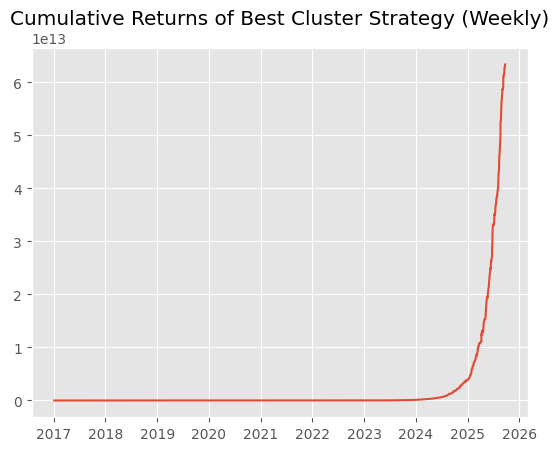

In [559]:
weekly_results_max = weekly_results.max(axis=1).to_frame('Max Strategy Return')
weekly_results_max = (1 + weekly_results_max['Max Strategy Return']).cumprod()-1
plt.plot(weekly_results_max.index, weekly_results_max.values)
plt.title('Cumulative Returns of Best Cluster Strategy (Weekly)')

[*********************100%***********************]  1 of 1 completed


<Axes: >

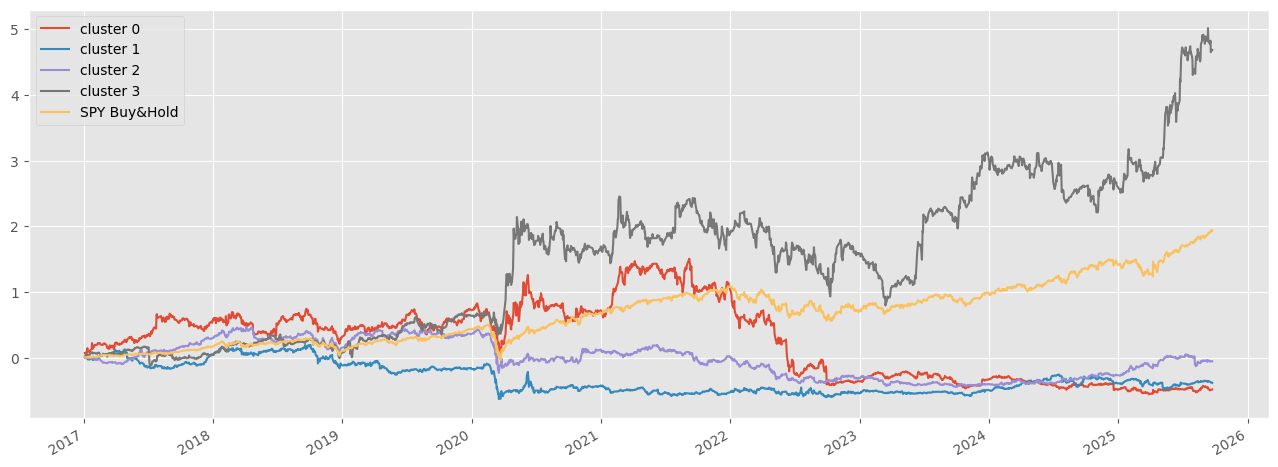

In [539]:
# plot weekly results
plt.style.use('ggplot')
spy = yf.download(tickers='SPY',
                  start='2017-01-01',
                  end=dt.date.today(), auto_adjust=False)
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1).droplevel(level=1, axis=1)
weekly_results = weekly_results.merge(spy_ret,left_index=True,right_index=True)
weekly_cumulative_return = np.exp(np.log1p(weekly_results)).cumprod()-1
weekly_cumulative_return.plot(figsize=(16,6))

Strategy ROI: 468.42%
Benchmark ROI: 191.01%
Strategy2 ROI: 293.87%
Best Strategy ROI: 217468204.69%


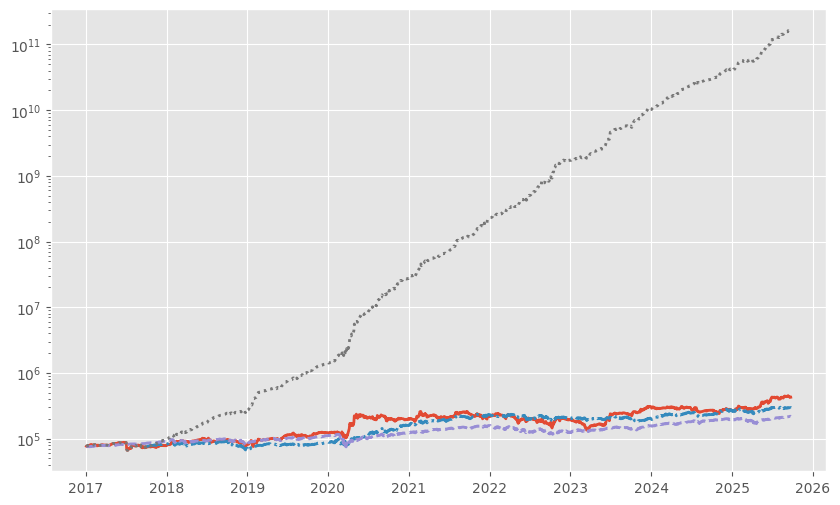

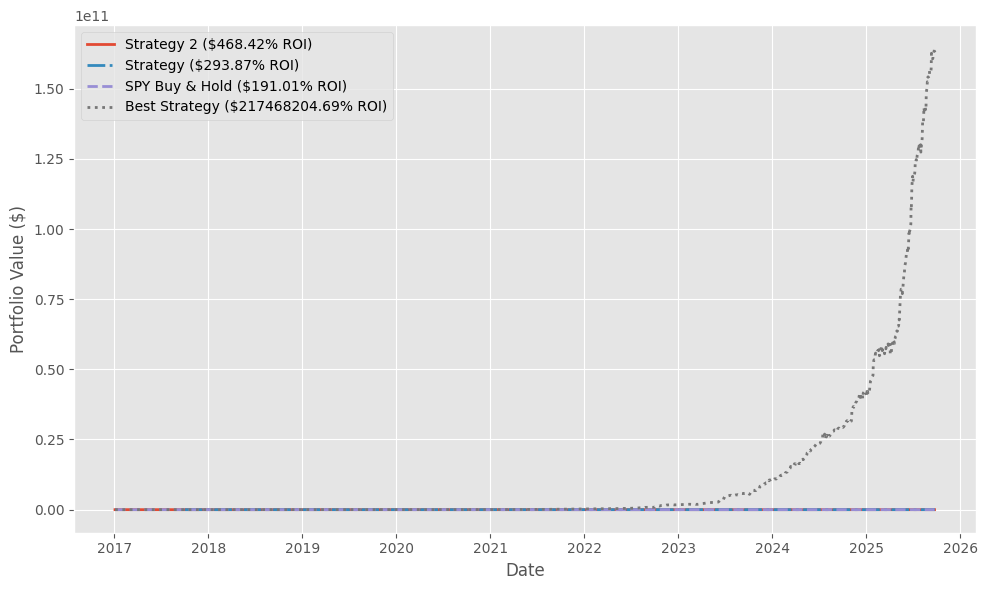

In [555]:

# Calculate cumulative returns
gross_rets = (1 + weekly_results['cluster 3']).cumprod()
gross_rets2 = (1 + all_results['cluster 3']).cumprod()
bench_rets = (1 + spy_ret['SPY Buy&Hold']).cumprod()
best_rets = pd.concat([weekly_results['cluster 3'], all_results['cluster 3']],axis=1).max(axis=1).to_frame('Strategy Return')
best_rets = (1 + best_rets['Strategy Return']).cumprod()


# Calculate investment values starting with $1000
initial_investment = 75_000
rets = gross_rets * initial_investment
b_rets = bench_rets * initial_investment
rets2 = gross_rets2 * initial_investment
best_rets = best_rets * initial_investment
# Calculate ROI
roi = ((rets.iloc[-1] - initial_investment) / initial_investment) * 100
roi2 = ((rets2.iloc[-1] - initial_investment) / initial_investment) * 100
b_roi = ((b_rets.iloc[-1] - initial_investment) / initial_investment) * 100
best_roi = ((best_rets.iloc[-1] - initial_investment) / initial_investment) * 100

# log scale plot
plt.figure(figsize=(10, 6))
plt.yscale('log')
plt.plot(rets, label=f'Strategy 2 (${roi:.2f}% ROI)', linewidth=2)
plt.plot(rets2, label=f'Strategy (${roi2:.2f}% ROI)', linestyle='-.', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)
plt.plot(best_rets, label=f'Best Strategy (${best_roi:.2f}% ROI)', linestyle=':', linewidth=2)

# Print ROI
print(f"Strategy ROI: {roi:.2f}%")
print(f"Benchmark ROI: {b_roi:.2f}%")
print(f"Strategy2 ROI: {roi2:.2f}%")
print(f"Best Strategy ROI: {best_roi:.2f}%")

# Plot both investment values
plt.figure(figsize=(10, 6))
plt.plot(rets, label=f'Strategy 2 (${roi:.2f}% ROI)', linewidth=2)
plt.plot(rets2, label=f'Strategy (${roi2:.2f}% ROI)', linestyle='-.', linewidth=2)
plt.plot(b_rets, label=f'SPY Buy & Hold (${b_roi:.2f}% ROI)', linestyle='--', linewidth=2)
plt.plot(best_rets, label=f'Best Strategy (${best_roi:.2f}% ROI)', linestyle=':', linewidth=2)

#plt.title('Value of $1000 Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# max between 


,Strategy Return
2017-01-04,0.019845
2017-01-05,0.010440
2017-01-06,0.002000
2017-01-09,0.007261
2017-01-10,-0.008504
...,...
2025-09-18,0.008301
2025-09-19,0.001396
2025-09-22,0.006206
2025-09-23,0.004972


In [524]:
weekly_results = weekly_results[:'2020-02-01']#['cluster 3']
monthly_results = all_results['2020-02-01':]['cluster 3']
weekly_results, monthly_results
strategy_2 = pd.concat([weekly_results, monthly_results])
strategy_2

,cluster 3
date,
2016-04-11,-0.002770
2016-04-12,0.006030
2016-04-13,0.003981
2016-04-14,-0.003769
2016-04-15,0.006193
...,...
2025-09-18,0.004577
2025-09-19,0.001396
2025-09-22,0.000589


In [525]:
## merge all_results and weekly_results on date index and change column name to Strategy Return
strategy = all_results.merge(strategy_2, left_index=True, right_index=True, how='inner').rename(columns={'cluster 3_x': 'cluster 3','cluster 3_y': 'Strategy 2 Return'})
strategy

,cluster 0,cluster 1,cluster 2,cluster 3,Strategy 2 Return
date,,,,,
2017-10-02,0.001049,0.002647,0.006540,0.004898,0.007548
2017-10-03,0.010966,0.004644,0.001415,0.002016,0.004062
2017-10-04,0.003787,0.004823,0.002813,-0.000218,0.003772
2017-10-05,0.001158,0.001221,0.003654,0.008617,0.001710
2017-10-06,-0.001590,0.001041,-0.005631,0.002516,0.002218
...,...,...,...,...,...
2025-09-18,0.007293,0.017845,-0.002321,0.004577,0.004577
2025-09-19,-0.001675,0.002304,-0.000243,0.001396,0.001396
2025-09-22,0.005423,-0.001174,-0.002843,0.000589,0.000589


In [526]:
weekly_results = weekly_results[:'2020-02-01']#['cluster 3']
monthly_results = all_results['2020-02-01':]['cluster 3']
weekly_results, monthly_results
strategy_2 = pd.concat([weekly_results, monthly_results])

strategy = all_results.merge(strategy_2, left_index=True, right_index=True, how='inner').rename(columns={'cluster 3_x': 'cluster 3','cluster 3_y': 'Strategy 2 Return'})
    
spy = yf.download(tickers='SPY',
                      start='2017-01-01',
                      end=dt.date.today(),
                      auto_adjust=False)
    
combined_data = {}
spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY'}, axis=1).droplevel(level=1, axis=1)
strategy = strategy.merge(spy_ret, left_index=True, right_index=True, how='inner')
portfolio_cumulative= np.exp(np.log1p(strategy).cumsum()) - 1

for group in portfolio_cumulative.columns:
    combined_data[group] = {
            'dates': portfolio_cumulative.index.strftime('%Y-%m-%d').tolist(),
            'cluster_returns': portfolio_cumulative[group].tolist(),
            'spy_returns': portfolio_cumulative['SPY'].tolist(),
           # 'daily_returns': portfolio_df[group].tolist()
    }


combined_data.keys()

[*********************100%***********************]  1 of 1 completed


dict_keys(['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'Strategy 2 Return', 'SPY'])